## Desafio Challenge 4I

### Feito por Arion Melkan de Freitas

In [1]:
# Importando as bibliotecas necessárias
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from pylab import rcParams
from sklearn.model_selection import train_test_split

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import lag_plot
from pmdarima import auto_arima

# Ignorar warnings não prejudiciais
import warnings
warnings.filterwarnings("ignore")

np.random.seed(0) 

%matplotlib inline

sns.set()

In [2]:
# Definindo os tamanhos das imagens desse notebook
rcParams['figure.figsize'] = 14, 10

#### Lendo os csv

In [3]:
# Recuperando os dados
pkgdir    = r'C:\Users\Arion\Downloads\Challenge_4i'
gov_stat  = 'data_comexstat.csv'
covariat  = 'covariates.xlsx' 
tfp       = 'TFP.csv' 

## Case 2

#### Fazendo a leitura dos dados

In [4]:
# Fazendo a leitura dos dados
df_govstat = pd.read_csv(f'{pkgdir}\\{gov_stat}', sep=',', encoding='latin-1')
#df_govstat = pd.read_csv(f'{gov_stat}', sep=',', encoding='latin-1')

# Visualizando os 5 primeiros registros
df_govstat.head(5)

date product state        country    type   route    tons       usd
0  1997-01-01    corn    ES  United States  Import     Sea  44.045  113029.0
1  1997-01-01    corn    GO      Argentina  Import  Ground  54.000   36720.0
2  1997-01-01    corn    GO        Bolivia  Export  Ground   0.200     180.0
3  1997-01-01    corn    GO  United States  Export     Sea   3.488    5688.0
4  1997-01-01    corn    MG      Argentina  Import  Ground  27.000   18630.0

#### Análise exploratória dos dados

In [5]:
def ExibirTiposVariaveis(df):
    for var in df:
        # imprime variavel e seu tipo
        print(f'{var} - tipo: {df[var].dtype.name}\n')
        
        # se nao é numérico
        if not np.issubdtype(df[var].dtype, np.number):
            print(f'Não numérico, valores:\n{df[var].unique()}\n')

In [6]:
ExibirTiposVariaveis(df_govstat)

date - tipo: object

Não numérico, valores:
['1997-01-01' '1997-02-01' '1997-03-01' '1997-04-01' '1997-05-01'
 '1997-06-01' '1997-07-01' '1997-08-01' '1997-09-01' '1997-10-01'
 '1997-11-01' '1997-12-01' '1998-01-01' '1998-02-01' '1998-03-01'
 '1998-04-01' '1998-05-01' '1998-06-01' '1998-07-01' '1998-08-01'
 '1998-09-01' '1998-10-01' '1998-11-01' '1998-12-01' '1999-01-01'
 '1999-02-01' '1999-03-01' '1999-04-01' '1999-05-01' '1999-06-01'
 '1999-07-01' '1999-08-01' '1999-09-01' '1999-10-01' '1999-11-01'
 '1999-12-01' '2000-01-01' '2000-02-01' '2000-03-01' '2000-04-01'
 '2000-05-01' '2000-06-01' '2000-07-01' '2000-08-01' '2000-09-01'
 '2000-10-01' '2000-11-01' '2000-12-01' '2001-01-01' '2001-02-01'
 '2001-03-01' '2001-04-01' '2001-05-01' '2001-06-01' '2001-07-01'
 '2001-08-01' '2001-09-01' '2001-10-01' '2001-11-01' '2001-12-01'
 '2002-01-01' '2002-02-01' '2002-03-01' '2002-04-01' '2002-05-01'
 '2002-06-01' '2002-07-01' '2002-08-01' '2002-09-01' '2002-10-01'
 '2002-11-01' '2002-12-01' '2003

In [7]:
# Método para exibir os possíveis valores nulos que tem no dataframe
def IdentificarValoresNulos(df):
    print(f'Os valores nulos são:\n{df.isna().sum()}')

In [8]:
IdentificarValoresNulos(df_govstat)

Os valores nulos são:
date       0
product    0
state      0
country    0
type       0
route      0
tons       0
usd        0
dtype: int64


In [9]:
# Método para listar os possíveis regsitros duplicados que possui no dataframe
def IdentificarValoresDuplicados(df):
    print(f'Os valores duplicados são:\n{df.duplicated().value_counts()}')

In [10]:
# Encontrando as linhas duplicadas e indentificando a quantidade de registros duplicados
IdentificarValoresDuplicados(df_govstat)

Os valores duplicados são:
False    117964
True          1
dtype: int64


In [11]:
print(f'Tamanho do Conjunto de Dados é:\n{df_govstat.shape}')

Tamanho do Conjunto de Dados é:
(117965, 8)


#### Análise da Estatística Descritiva

In [12]:
df_govstat.describe()

tons           usd
count  1.179650e+05  1.179650e+05
mean   1.453681e+04  4.813150e+06
std    4.977926e+04  1.949412e+07
min    0.000000e+00  0.000000e+00
25%    1.249000e+02  7.155200e+04
50%    2.000000e+03  7.250000e+05
75%    1.353403e+04  3.895943e+06
max    1.798446e+06  9.039304e+08

### Show the evolution of total monthly and total annual exports from Brazil (all states and to everywhere) of ‘soybeans’, ‘soybean oil’ and ‘soybean meal’;

In [13]:
attr = 'date'
lst_new_attr = ['year', 'month']

# Criando as novas colunas de ano e mês
df_govstat[lst_new_attr[0]] = pd.DatetimeIndex(df_govstat[attr]).year
df_govstat[lst_new_attr[1]] = pd.DatetimeIndex(df_govstat[attr]).month

df_govstat.head(3)

date product state        country    type   route    tons       usd  \
0  1997-01-01    corn    ES  United States  Import     Sea  44.045  113029.0   
1  1997-01-01    corn    GO      Argentina  Import  Ground  54.000   36720.0   
2  1997-01-01    corn    GO        Bolivia  Export  Ground   0.200     180.0   

   year  month  
0  1997      1  
1  1997      1  
2  1997      1

In [14]:
lst_product = ['soybeans', 'soybean_oil', 'soybean_meal']
tp = 'Export'

df = df_govstat\
        .query('type == @tp & product == @lst_product')

df.head(5)

date       product state      country    type route       tons  \
19  1997-01-01  soybean_meal    GO  Netherlands  Export   Sea    419.070   
20  1997-01-01  soybean_meal    GO  Netherlands  Export   Sea   5000.000   
21  1997-01-01  soybean_meal    MS      Germany  Export   Sea    140.672   
22  1997-01-01  soybean_meal    MS      Hungary  Export   Sea  15000.000   
23  1997-01-01  soybean_meal    MS  Netherlands  Export   Sea  14000.000   

          usd  year  month  
19   119318.0  1997      1  
20  1414250.0  1997      1  
21    38378.0  1997      1  
22  4042100.0  1997      1  
23  3850162.0  1997      1

#### Soybeans

In [15]:
# Separando os três produtos
sb = df.query('product == "soybeans"')

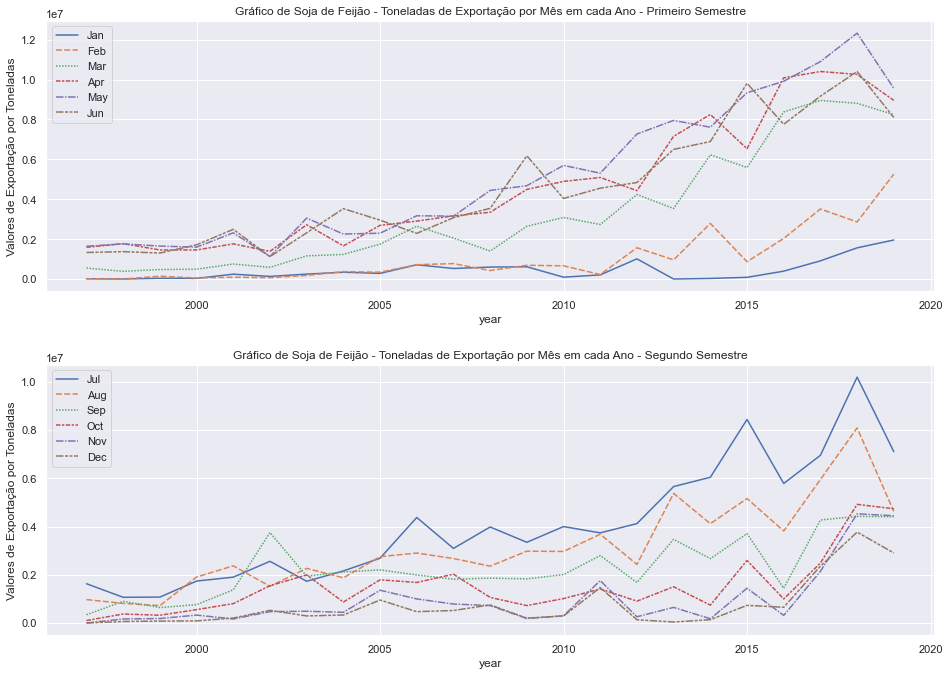

In [16]:
# Renomeando as colunas para ficar mais intuitivo
dc_columns = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug',
              9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}

# Inicializando os atributos que eu trabalharei
lst_attr = ['year', 'month', 'product']

# Agrupando pela lista e realizando a soma e renomeando a colunas tons.
# Por fim faço o reset do index para depois realizar o pivot
soybean_tons = sb.groupby(lst_attr).agg(total_toneladas=('tons', 'sum')).reset_index()

# Fazendo o pivot e transformando ano em índice, mês em colunas e total_toneladas os valores
soybean = soybean_tons.pivot("year", "month", "total_toneladas")

# Renomeando o nome das colunas a partir do dicionário dc_columns
soybean = soybean.rename(columns=dc_columns)

fig = plt.figure()
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.title.set_text('Gráfico de Soja de Feijão - Toneladas de Exportação por Mês em cada Ano - Primeiro Semestre');
ax1.set_ylabel('Valores de Exportação por Toneladas');
ax1.set_xlabel('Anos');
sns.lineplot(data = soybean.iloc[:,0:6], ax = ax1);

fig.tight_layout(pad=3.0)

ax2.title.set_text('Gráfico de Soja de Feijão - Toneladas de Exportação por Mês em cada Ano - Segundo Semestre');
ax2.set_ylabel('Valores de Exportação por Toneladas');
ax2.set_xlabel('Anos');
sns.lineplot(data = soybean.iloc[:,6:12], ax = ax2);

#### Soybeans Oil

In [17]:
sbo = df.query('product == "soybean_oil"')

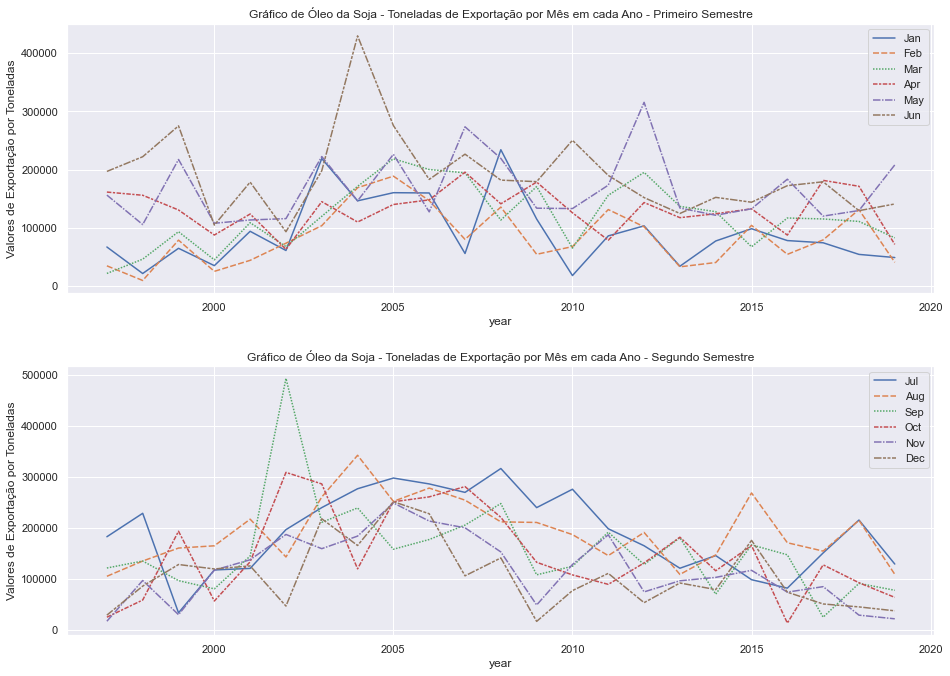

In [18]:
# Agrupando pela lista e realizando a soma e renomeando a colunas tons.
# Por fim faço o reset do index para depois realizar o pivot
soybean_oil_tons = sbo.groupby(lst_attr).agg(total_toneladas=('tons', 'sum')).reset_index()

# Fazendo o pivot e transformando ano em índice, mês em colunas e total_toneladas os valores
soybean_oil = soybean_oil_tons.pivot("year", "month", "total_toneladas")

# Renomeando o nome das colunas a partir do dicionário dc_columns
soybean_oil = soybean_oil.rename(columns=dc_columns)

fig = plt.figure()
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.title.set_text('Gráfico de Óleo da Soja - Toneladas de Exportação por Mês em cada Ano - Primeiro Semestre');
ax1.set_ylabel('Valores de Exportação por Toneladas');
ax1.set_xlabel('Anos');
sns.lineplot(data = soybean_oil.iloc[:,0:6], ax = ax1);

fig.tight_layout(pad=3.0)

ax2.title.set_text('Gráfico de Óleo da Soja - Toneladas de Exportação por Mês em cada Ano - Segundo Semestre');
ax2.set_ylabel('Valores de Exportação por Toneladas');
ax2.set_xlabel('Anos');
sns.lineplot(data = soybean_oil.iloc[:,6:12], ax = ax2);

#### Soybean Meal

In [19]:
sbm = df.query('product == "soybean_meal"')

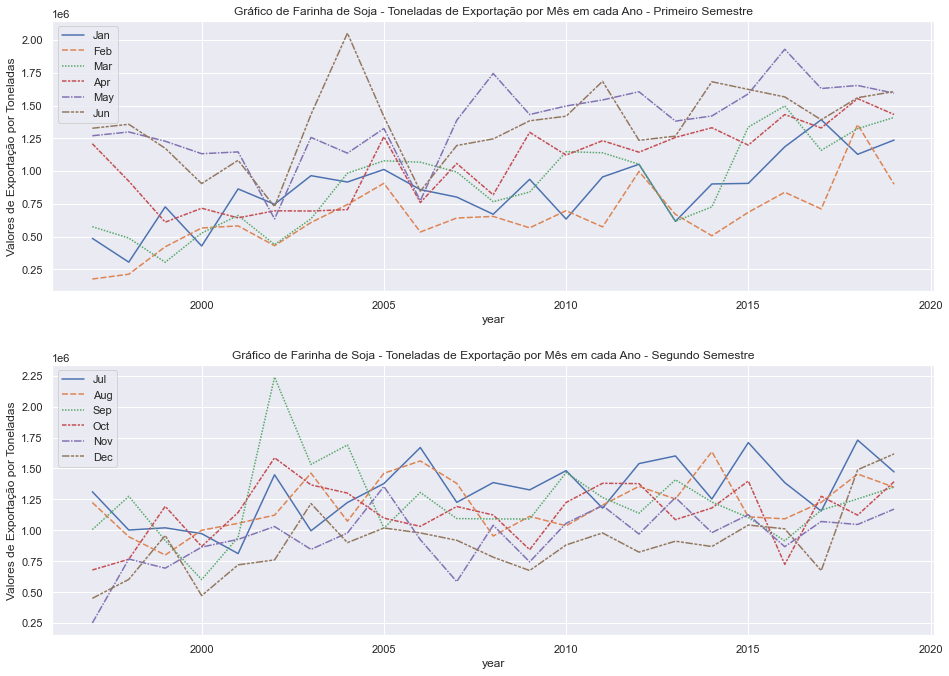

In [20]:
# Agrupando pela lista e realizando a soma e renomeando a colunas tons.
# Por fim faço o reset do index para depois realizar o pivot
soybean_meal_tons = sbm.groupby(lst_attr).agg(total_toneladas=('tons', 'sum')).reset_index()

# Fazendo o pivot e transformando ano em índice, mês em colunas e total_toneladas os valores
soybean_meal = soybean_meal_tons.pivot("year", "month", "total_toneladas")

# Renomeando o nome das colunas a partir do dicionário dc_columns
soybean_meal = soybean_meal.rename(columns=dc_columns)

fig = plt.figure()
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.title.set_text('Gráfico de Farinha de Soja - Toneladas de Exportação por Mês em cada Ano - Primeiro Semestre');
ax1.set_ylabel('Valores de Exportação por Toneladas');
ax1.set_xlabel('Anos');
sns.lineplot(data = soybean_meal.iloc[:,0:6], ax = ax1);

fig.tight_layout(pad=3.0)

ax2.title.set_text('Gráfico de Farinha de Soja - Toneladas de Exportação por Mês em cada Ano - Segundo Semestre');
ax2.set_ylabel('Valores de Exportação por Toneladas');
ax2.set_xlabel('Anos');
sns.lineplot(data = soybean_meal.iloc[:,6:12], ax = ax2);

### What are the 3 most important products exported by Brazil in the last 5 years?

#### Avaliando pelo número de exportação

In [21]:
# Primeiro farei a consulta para recuperar os últimos cincos anos.
df_last_five_years = df_govstat.query('year == 2015 | year == 2016 | year == 2017 | year == 2018 | year == 2019')

# Segundo farei a consulta olhando somente os produtos de exportação
df_export_products = df_last_five_years.query('type == "Export"')

# Terceiro farei o cálculo do número de exportações para identificar os 3 maiores produtos exportados durante os últimos 5 anos
lst_attr = ['product']
attr = 'tons'

# Agruparei somente pelo produto porque eu considerarei a soma total das exportações realizadas pelo produto nos cinco anos.
df_most_ex_product = df_export_products.groupby(lst_attr)[attr].apply(lambda x: x.sum())

# Ordenando os valores de forma que o dataframe possua os três primeiros produtos mais importantes exportados no Brasil
df_most_ex_product = df_most_ex_product.sort_values(ascending=False)

print(f'Os três primeiros produtos mais comercializados nos últimos cinco anos - Análise do atributo tons:\n'
      f'{df_most_ex_product}')

Os três primeiros produtos mais comercializados nos últimos cinco anos - Análise do atributo tons:
product
soybeans        3.263315e+08
corn            1.445993e+08
sugar           1.200336e+08
soybean_meal    7.664749e+07
soybean_oil     6.711428e+06
wheat           3.885836e+06
Name: tons, dtype: float64


In [22]:
df_most_ex_prod = df_most_ex_product.reset_index()[0:3]
df_most_ex_prod

product          tons
0  soybeans  3.263315e+08
1      corn  1.445993e+08
2     sugar  1.200336e+08

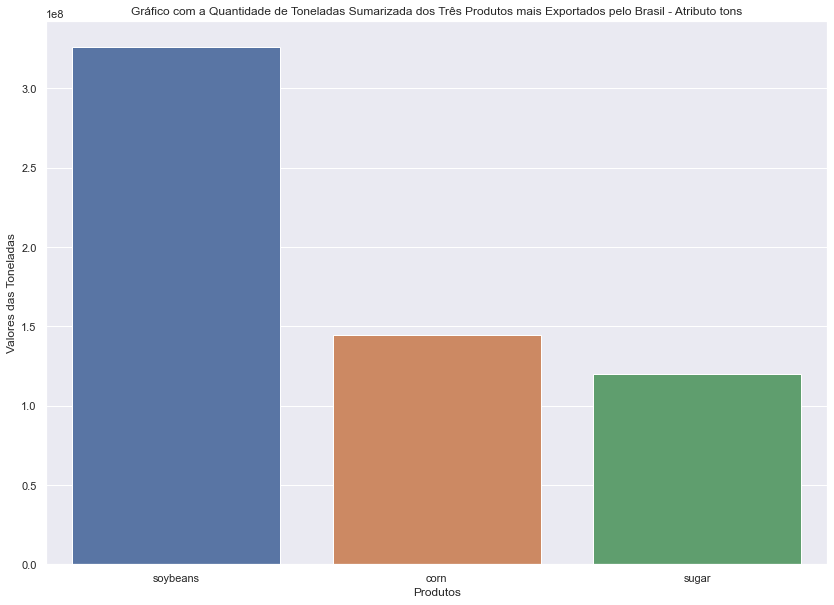

In [23]:
sns.barplot(data = df_most_ex_prod, x = 'product', y = 'tons');
plt.title('Gráfico com a Quantidade de Toneladas Sumarizada dos Três Produtos mais Exportados pelo Brasil - Atributo tons');
plt.xlabel('Produtos');
plt.ylabel('Valores das Toneladas');

#### Avaliando pelo dinheiro arrecadado - USD

In [24]:
# Inicializando
lst_attr = ['product']
attr = 'usd'

# Agruparei somente pelo produto porque eu considerarei a soma total das exportações realizadas pelo produto nos cinco anos.
df_most_ex_productb = df_export_products.groupby(lst_attr)[attr].apply(lambda x: x.sum())

# Ordenando os valores de forma que o dataframe possua os três primeiros produtos mais importantes exportados no Brasil
df_most_ex_productb = df_most_ex_productb.sort_values(ascending=False)

print(f'Os três primeiros produtos mais comercializados nos últimos cinco anos - Análise do atributo usd:\n'
      f'{df_most_ex_productb}')

Os três primeiros produtos mais comercializados nos últimos cinco anos - Análise do atributo usd:
product
soybeans        1.233255e+11
sugar           4.093849e+10
soybean_meal    2.840772e+10
corn            2.444772e+10
soybean_oil     4.795947e+09
wheat           7.269454e+08
Name: usd, dtype: float64


In [25]:
df_most_ex_prodb = df_most_ex_productb.reset_index()[0:3]
df_most_ex_prodb

product           usd
0      soybeans  1.233255e+11
1         sugar  4.093849e+10
2  soybean_meal  2.840772e+10

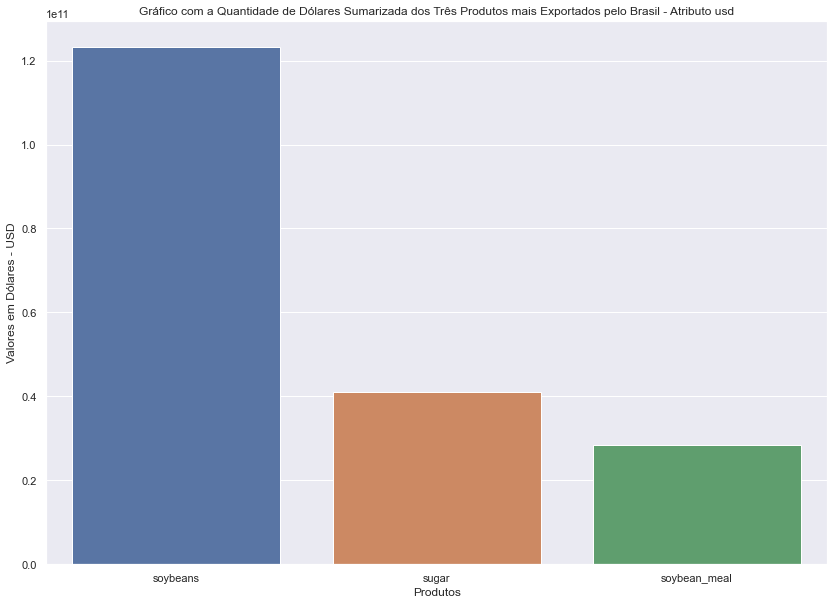

In [26]:
sns.barplot(data = df_most_ex_prodb, x = 'product', y = 'usd');
plt.title('Gráfico com a Quantidade de Dólares Sumarizada dos Três Produtos mais Exportados pelo Brasil - Atributo usd');
plt.xlabel('Produtos');
plt.ylabel('Valores em Dólares - USD');

<span style='color:black'>
    A minha primeira análise foi em relação a quantidade de produtos, em toneladas exportadas, pelo Brasil durante os últimos cinco anos. Compreende-se que soja de Feijão, Milho e Açúcar foram os mais importantes nestes últimos anos.<br>Aqui, eu fiz os valores sumarizados, do campo tons, para obter o resultado que mostrasse os produtos mais importantes ao invés de listar ano por ano os produtos mais importantes, embora mesmo agrupando por ano, a sequência elencada dos produtos acima ocorreria da mesma forma.
    <br>
    <br>
    Depois a última análise foi para obter a relação dos produtos que foram exportados, mas tiveram retornos mais importantes. Esta análise foi através do campo, usd. E mesmo que os dois primeiros produtos estejam na primeira análise, a farinha de soja obteve um maior retorno em relação ao açúcar.<br>Neste ponto, podemos inferir que o produto açúcar é mais barato em relação a farinha de soja, pois mesmo com mais exportação, o retorno foi um pouco menor.
</span>

### What are the main routes through which Brazil have been exporting ‘corn’ in the last few years? Are there differences in the relative importancem of routes depending on the product?

#### Análise das Rotas - Somente o Produto Milho

##### Usando o atributo tons para compreender a questão

In [27]:
# Inicializando a lista com anos
lst_years = [2016, 2017, 2018, 2019]

# Primeiro farei um dataframe do tipo de produto exportado com milho e analisando nos últimos 4 anos
df_ex_corn = df_govstat.query('type == "Export" & product == "corn" & year == @lst_years')

# Inicializando
lst_attr = ['route']
attr = 'tons'

# Agruparei somente pelo produto porque eu considerarei a soma total das exportações realizadas pelas rotas nos últimos anos.
df_most_ex_corn = df_ex_corn.groupby(lst_attr)[attr].apply(lambda x: x.sum())

# Ordenando os valores de forma que o dataframe possua as rotas mais importantes do produto milho
df_most_ex_corn = df_most_ex_corn.sort_values(ascending=False)

print(f'As rotas mais importantes com o produto milho: - Atributo tons\n'
      f'{df_most_ex_corn.head(5)}')

As rotas mais importantes com o produto milho: - Atributo tons
route
Sea       1.111515e+08
River     4.220893e+06
Other     2.642741e+05
Ground    6.179238e+04
Air       5.043010e+02
Name: tons, dtype: float64


In [28]:
df_most_rt_corn = df_most_ex_corn.reset_index()
df_most_rt_corn

route          tons
0     Sea  1.111515e+08
1   River  4.220893e+06
2   Other  2.642741e+05
3  Ground  6.179238e+04
4     Air  5.043010e+02

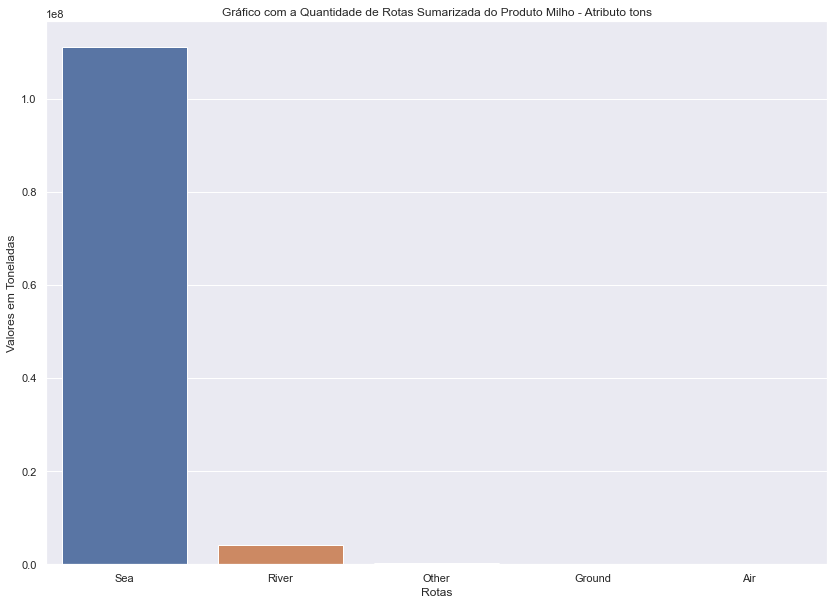

In [29]:
sns.barplot(data = df_most_rt_corn, x = 'route', y = 'tons');
plt.title('Gráfico com a Quantidade de Rotas Sumarizada do Produto Milho - Atributo tons');
plt.xlabel('Rotas');
plt.ylabel('Valores em Toneladas');

##### Usando o atributo usd para compreender a questão

In [30]:
# Inicializando
lst_attr = ['route']
attr = 'usd'

# Agruparei somente pelo produto porque eu considerarei a soma total das exportações realizadas pelas rotas nos últimos anos.
df_most_ex_cornb = df_ex_corn.groupby(lst_attr)[attr].apply(lambda x: x.sum())

# Ordenando os valores de forma que o dataframe possua as rotas mais importantes do produto milho
df_most_ex_cornb = df_most_ex_cornb.sort_values(ascending=False)

print(f'As rotas mais importantes com o produto milho - Atributo usd:\n'
      f'{df_most_ex_cornb.head(5)}')

As rotas mais importantes com o produto milho - Atributo usd:
route
Sea       1.856034e+10
River     6.881527e+08
Ground    1.506524e+08
Other     4.388674e+07
Air       2.498481e+06
Name: usd, dtype: float64


In [31]:
df_most_rt_cornb = df_most_ex_cornb.reset_index()
df_most_rt_cornb

route           usd
0     Sea  1.856034e+10
1   River  6.881527e+08
2  Ground  1.506524e+08
3   Other  4.388674e+07
4     Air  2.498481e+06

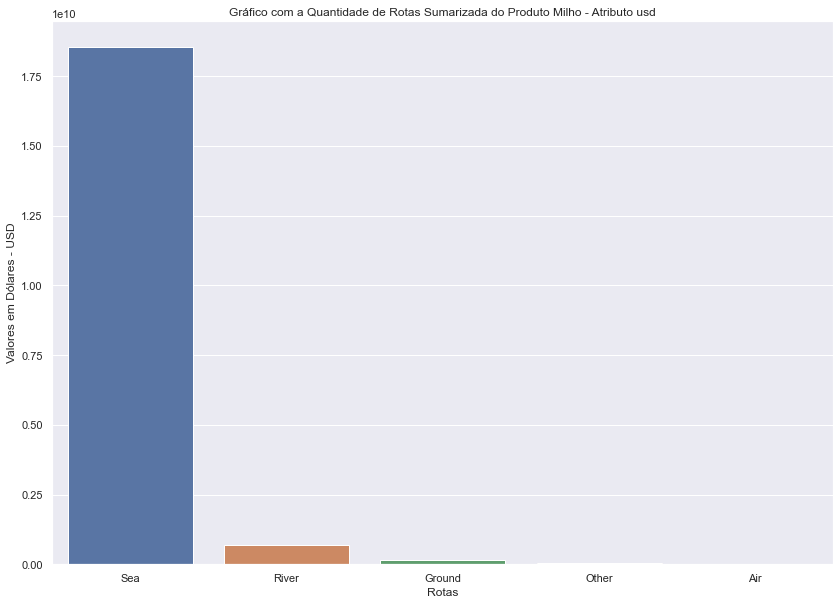

In [32]:
sns.barplot(data = df_most_rt_cornb, x = 'route', y = 'usd');
plt.title('Gráfico com a Quantidade de Rotas Sumarizada do Produto Milho - Atributo usd');
plt.xlabel('Rotas');
plt.ylabel('Valores em Dólares - USD');

<span style='color:black'>
    Mesmo avaliando com visão de campos diferentes, seja tons ou usd, a rota mais predominante do produto milho é via marítima, mar, e em segundo mais distante do primeiro lugar o transporte fluvial, rios. Se for analisarmos o Brasil, temos muitas rotas fluviais e portos localizados em Santos, Rio de Janeiro e em algumas regiões do Nordeste, facilitando o transporte por essas rotas, além de ser um meio mais barato do que transporte áereo.
</span>

#### Análise das Rotas - Demais Produtos

##### Utilizando o atributo tons para avaliar a questão

In [33]:
# Inicializando a lista com anos
lst_years = [2016, 2017, 2018, 2019]

# Primeiro farei um dataframe do tipo de produto exportado com produtos diferentes do milho e analisando nos últimos 4 anos
df_ex_rt_prod = df_govstat.query('type == "Export" & product != "corn" & year == @lst_years')

# Inicializando
lst_attr = ['route']
attr = 'tons'

# Agruparei somente pelo produto porque eu considerarei a soma total das exportações realizadas pelas rotas nos últimos anos.
df_most_rt_prod = df_ex_rt_prod.groupby(lst_attr)[attr].apply(lambda x: x.sum())

# Ordenando os valores de forma que o dataframe possua as rotas mais importantes com outros produtos
df_most_rt_prod = df_most_rt_prod.sort_values(ascending=False)

print(f'As rotas mais importantes com os produtos diferentes de milho: - Atributo tons\n'
      f'{df_most_rt_prod.head(5)}')

As rotas mais importantes com os produtos diferentes de milho: - Atributo tons
route
Sea       4.272074e+08
River     7.574603e+06
Other     1.672366e+06
Ground    7.450662e+05
Air       2.210083e+04
Name: tons, dtype: float64


In [34]:
df_most_rt_prodt = df_most_rt_prod.reset_index()
df_most_rt_prodt

route          tons
0     Sea  4.272074e+08
1   River  7.574603e+06
2   Other  1.672366e+06
3  Ground  7.450662e+05
4     Air  2.210083e+04

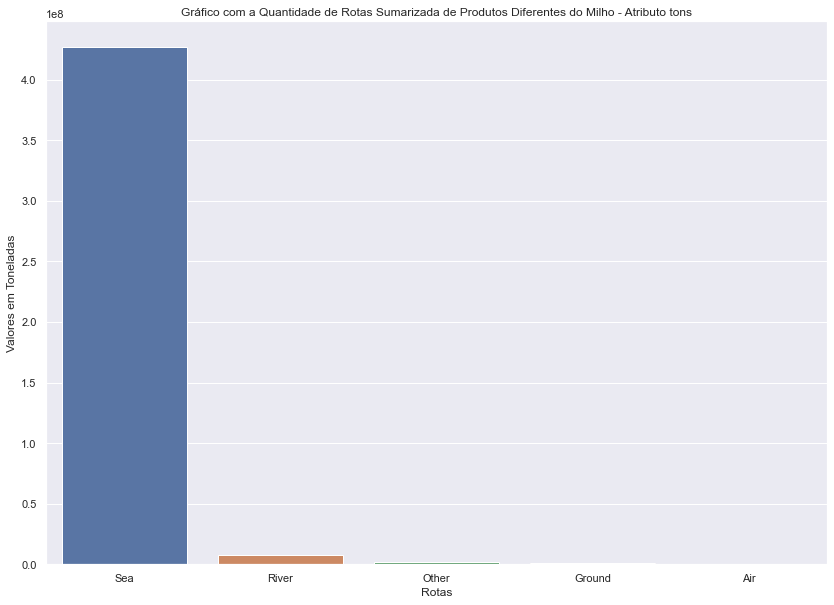

In [35]:
sns.barplot(data = df_most_rt_prodt, x = 'route', y = 'tons');
plt.title('Gráfico com a Quantidade de Rotas Sumarizada de Produtos Diferentes do Milho - Atributo tons');
plt.xlabel('Rotas');
plt.ylabel('Valores em Toneladas');

#### Utilizando o atributo usd para entender a questão

In [36]:
# Inicializando
lst_attr = ['route']
attr = 'usd'

# Agruparei somente pelo produto porque eu considerarei a soma total das exportações realizadas pelas rotas nos últimos anos.
df_most_rt_prodb = df_ex_rt_prod.groupby(lst_attr)[attr].apply(lambda x: x.sum())

# Ordenando os valores de forma que o dataframe possua as rotas mais importantes com outros produtos
df_most_rt_prodb = df_most_rt_prodb.sort_values(ascending=False)

print(f'As rotas mais importantes com os produtos diferentes de milho: - Atributo usd\n'
      f'{df_most_rt_prodb.head(5)}')

As rotas mais importantes com os produtos diferentes de milho: - Atributo usd
route
Sea       1.584709e+11
River     2.858863e+09
Other     6.115188e+08
Ground    3.712138e+08
Air       8.158269e+06
Name: usd, dtype: float64


In [37]:
df_most_rt_produ = df_most_rt_prodb.reset_index()
df_most_rt_produ

route           usd
0     Sea  1.584709e+11
1   River  2.858863e+09
2   Other  6.115188e+08
3  Ground  3.712138e+08
4     Air  8.158269e+06

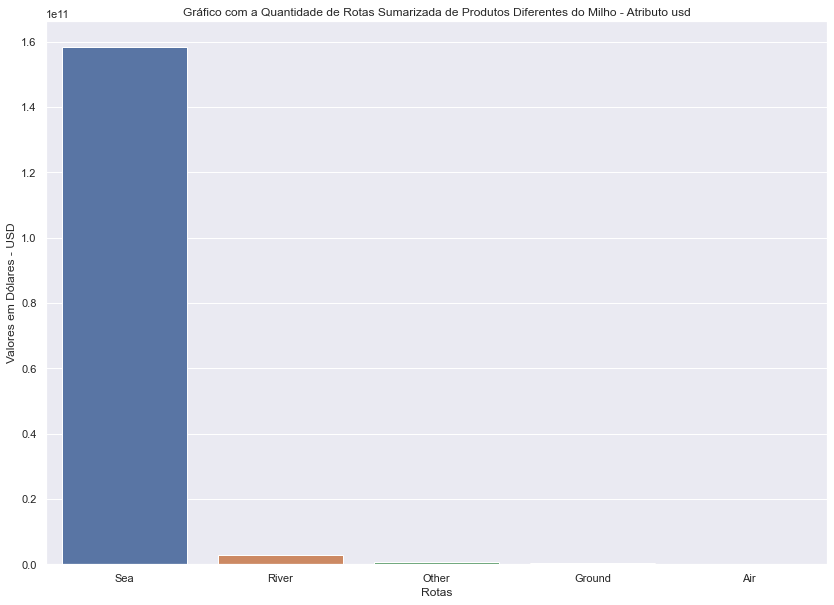

In [38]:
sns.barplot(data = df_most_rt_produ, x = 'route', y = 'usd');
plt.title('Gráfico com a Quantidade de Rotas Sumarizada de Produtos Diferentes do Milho - Atributo usd');
plt.xlabel('Rotas');
plt.ylabel('Valores em Dólares - USD');

<span style='color:black'>
    Mesmo com os demais produtos, exceto o Milho, e olhando os dois cenários: Sumarizando a toneladas e dólares, o resultado é o mesmo, via marítima é a rota mais importante no Brasil, seguido por vias fluvias e outras rotas.<br>Para se ter uma ideia, a segunda rota, rios, está bem distante da rota mais importante. <br><br> Segundo a análise, hoje não há diferença relativa entre as rotas para esses cinco produtos. Embora, se fossêmos analisar produto a produto, pode ser que ocorra alguma diferença entre as rotas: rios, outros, terras e aérea. <br>Por exemplo o produto trigo ele só possui quatro rotas: Mar, Outros, Terra e Aérea, sendo que Mar é a rota mais importante, seguida por Terra.
</span>

### Which countries have been the most important trade partners for Brazil in terms of ‘corn’ and ‘sugar’ in the last 3 years?

#### Análise com o atributo USD

In [39]:
# Inicializando a lista com anos
lst_years = [2017, 2018, 2019]
lst_prods = ['corn', 'sugar']

# Países que exportam e mantém importantes relações comerciais com o Brasil, olhando os produtos milho e açúcar
df_countries_partners_exp = df_govstat.query('product == @lst_prods & year == @lst_years & type == "Export"')

# Países que importamos e mantém importantes relações comerciais com o Brasil, olhando os produtos milho e açúcar
df_countries_partners_imp = df_govstat.query('product == @lst_prods & year == @lst_years & type == "Import"')

# Inicializando as variáveis
lst_attr = ['country','type']
attr = 'usd'

# Agrupando pelo país e o tipo, Exportação, alémm de sumarizar o valor em dólar
df_most_cntrs_exp = df_countries_partners_exp.groupby(lst_attr)[attr].apply(lambda x: x.sum())

# Ordenando os valores de forma que o dataframe possua os países com relação comercial mais importante
df_most_cntrs_exp = df_most_cntrs_exp.sort_values(ascending=False)

# Agrupando pelo país e o tipo, Importação, alémm de sumarizar o valor em dólar
df_most_cntrs_imp = df_countries_partners_imp.groupby(lst_attr)[attr].apply(lambda x: x.sum())

# Ordenando os valores de forma que o dataframe possua os países com relação comercial mais importante
df_most_cntrs_imp = df_most_cntrs_imp.sort_values(ascending=False)

In [40]:
print(f'Os países com relação comercial mais importantes com o Brasil - Exportadores em análise do Dólar:\n'
      f'{df_most_cntrs_exp.head(10)}')

Os países com relação comercial mais importantes com o Brasil - Exportadores em análise do Dólar:
country               type  
Iran                  Export    3.302428e+09
Bangladesh            Export    2.591054e+09
Algeria               Export    2.441462e+09
Egypt                 Export    2.385649e+09
Malaysia              Export    1.735365e+09
India                 Export    1.704340e+09
Saudi Arabia          Export    1.680493e+09
United Arab Emirates  Export    1.595027e+09
Japan                 Export    1.577629e+09
Vietnam               Export    1.555211e+09
Name: usd, dtype: float64


In [41]:
print(f'Os países com relação comercial mais importantes com o Brasil - Importando os seus Produtos em análise do Dólar:\n'
      f'{df_most_cntrs_imp.head(10)}')

Os países com relação comercial mais importantes com o Brasil - Importando os seus Produtos em análise do Dólar:
country        type  
Paraguay       Import    374247027.0
Argentina      Import    155419774.0
United States  Import     24141814.0
Bolivia        Import      2500841.0
Chile          Import       610812.0
Italy          Import       355682.0
Netherlands    Import       285032.0
Germany        Import       270233.0
Switzerland    Import       204303.0
Mexico         Import       148917.0
Name: usd, dtype: float64


In [42]:
df_most_ctr_exp = df_most_cntrs_exp.reset_index()[0:10]
df_most_ctr_exp

country    type           usd
0                  Iran  Export  3.302428e+09
1            Bangladesh  Export  2.591054e+09
2               Algeria  Export  2.441462e+09
3                 Egypt  Export  2.385649e+09
4              Malaysia  Export  1.735365e+09
5                 India  Export  1.704340e+09
6          Saudi Arabia  Export  1.680493e+09
7  United Arab Emirates  Export  1.595027e+09
8                 Japan  Export  1.577629e+09
9               Vietnam  Export  1.555211e+09

In [43]:
df_most_ctr_imp = df_most_cntrs_imp.reset_index()[0:10]
df_most_ctr_imp

country    type          usd
0       Paraguay  Import  374247027.0
1      Argentina  Import  155419774.0
2  United States  Import   24141814.0
3        Bolivia  Import    2500841.0
4          Chile  Import     610812.0
5          Italy  Import     355682.0
6    Netherlands  Import     285032.0
7        Germany  Import     270233.0
8    Switzerland  Import     204303.0
9         Mexico  Import     148917.0

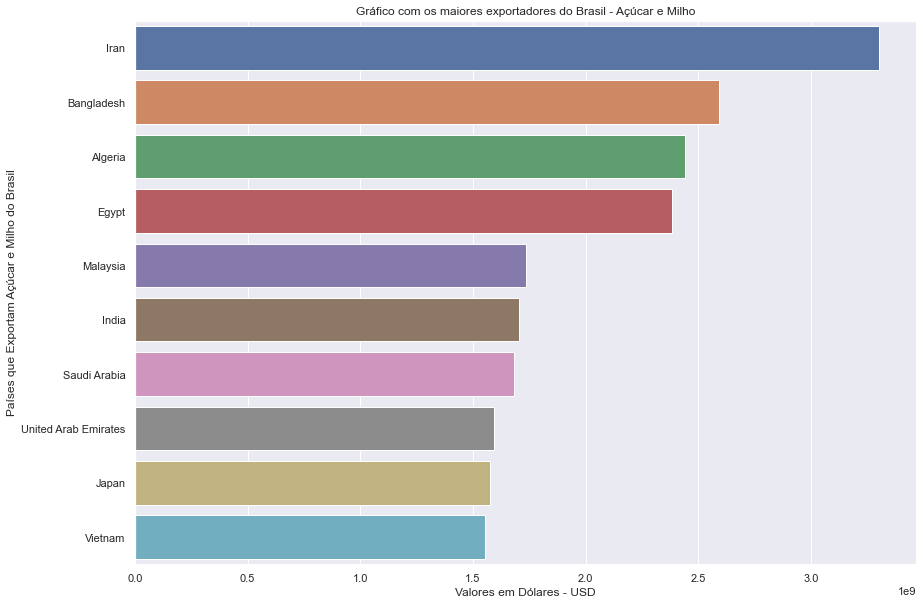

In [44]:
sns.barplot(data = df_most_ctr_exp, x = 'usd', y = 'country');
plt.title('Gráfico com os maiores exportadores do Brasil - Açúcar e Milho');
plt.xlabel('Valores em Dólares - USD');
plt.ylabel('Países que Exportam Açúcar e Milho do Brasil');

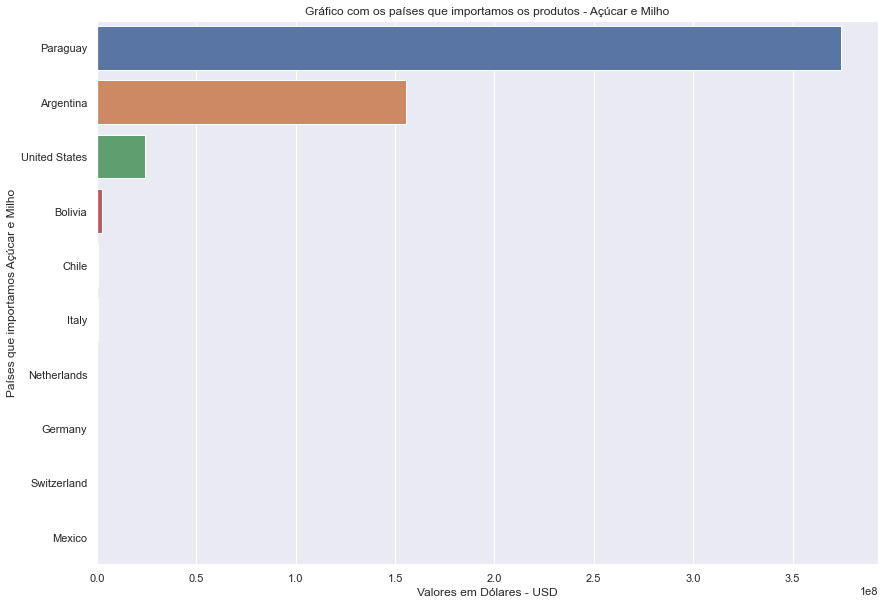

In [45]:
sns.barplot(data = df_most_ctr_imp, x = 'usd', y = 'country');
plt.title('Gráfico com os países que importamos os produtos - Açúcar e Milho');
plt.xlabel('Valores em Dólares - USD');
plt.ylabel('Países que importamos Açúcar e Milho');

#### Análise com o atributo tons

In [46]:
# Inicializando as variáveis
lst_attr = ['country','type']
attr = 'tons'

# Agrupando pelo país e o tipo, Exportação, alémm de sumarizar o valor em dólar
df_most_cntrs_expt = df_countries_partners_exp.groupby(lst_attr)[attr].apply(lambda x: x.sum())

# Ordenando os valores de forma que o dataframe possua os países com relação comercial mais importante
df_most_cntrs_expt = df_most_cntrs_expt.sort_values(ascending=False)

# Agrupando pelo país e o tipo, Importação, alémm de sumarizar o valor em dólar
df_most_cntrs_impt = df_countries_partners_imp.groupby(lst_attr)[attr].apply(lambda x: x.sum())

# Ordenando os valores de forma que o dataframe possua os países com relação comercial mais importante
df_most_cntrs_impt = df_most_cntrs_impt.sort_values(ascending=False)

In [47]:
print(f'Os países com relação comercial mais importantes com o Brasil - Exportadores em análise de toneladas:\n'
      f'{df_most_cntrs_expt.head(10)}')

Os países com relação comercial mais importantes com o Brasil - Exportadores em análise de toneladas:
country       type  
Iran          Export    1.785774e+07
Egypt         Export    1.142502e+07
Japan         Export    9.679768e+06
Bangladesh    Export    9.560076e+06
Vietnam       Export    9.456969e+06
Spain         Export    8.377581e+06
Algeria       Export    8.315540e+06
Malaysia      Export    7.220061e+06
South Korea   Export    6.287521e+06
Saudi Arabia  Export    6.060316e+06
Name: tons, dtype: float64


In [48]:
print(f'Os países com relação comercial mais importantes com o Brasil - Importando os seus Produtos em análise de toneladas:\n'
      f'{df_most_cntrs_impt.head(10)}')

Os países com relação comercial mais importantes com o Brasil - Importando os seus Produtos em análise de toneladas:
country        type  
Paraguay       Import    2842389.539
Argentina      Import     819866.084
United States  Import       6488.272
Bolivia        Import        955.531
Chile          Import        700.000
Guatemala      Import        320.050
Italy          Import        291.596
Germany        Import         86.012
Netherlands    Import         77.241
Indonesia      Import         34.020
Name: tons, dtype: float64


In [49]:
df_most_ctr_expt = df_most_cntrs_expt.reset_index()[0:10]
df_most_ctr_expt

country    type          tons
0          Iran  Export  1.785774e+07
1         Egypt  Export  1.142502e+07
2         Japan  Export  9.679768e+06
3    Bangladesh  Export  9.560076e+06
4       Vietnam  Export  9.456969e+06
5         Spain  Export  8.377581e+06
6       Algeria  Export  8.315540e+06
7      Malaysia  Export  7.220061e+06
8   South Korea  Export  6.287521e+06
9  Saudi Arabia  Export  6.060316e+06

In [50]:
df_most_ctr_impt = df_most_cntrs_impt.reset_index()[0:10]
df_most_ctr_impt

country    type         tons
0       Paraguay  Import  2842389.539
1      Argentina  Import   819866.084
2  United States  Import     6488.272
3        Bolivia  Import      955.531
4          Chile  Import      700.000
5      Guatemala  Import      320.050
6          Italy  Import      291.596
7        Germany  Import       86.012
8    Netherlands  Import       77.241
9      Indonesia  Import       34.020

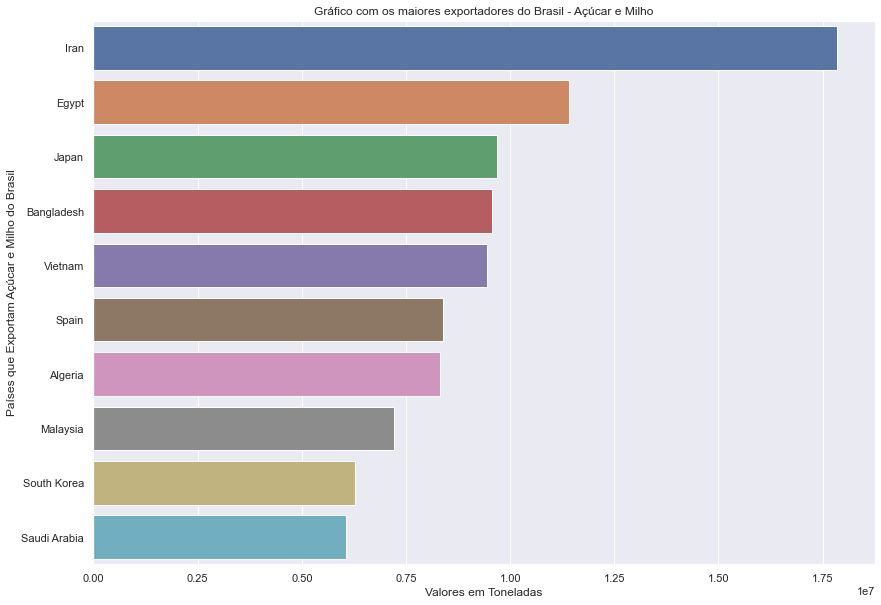

In [51]:
sns.barplot(data = df_most_ctr_expt, x = 'tons', y = 'country');
plt.title('Gráfico com os maiores exportadores do Brasil - Açúcar e Milho');
plt.xlabel('Valores em Toneladas');
plt.ylabel('Países que Exportam Açúcar e Milho do Brasil');

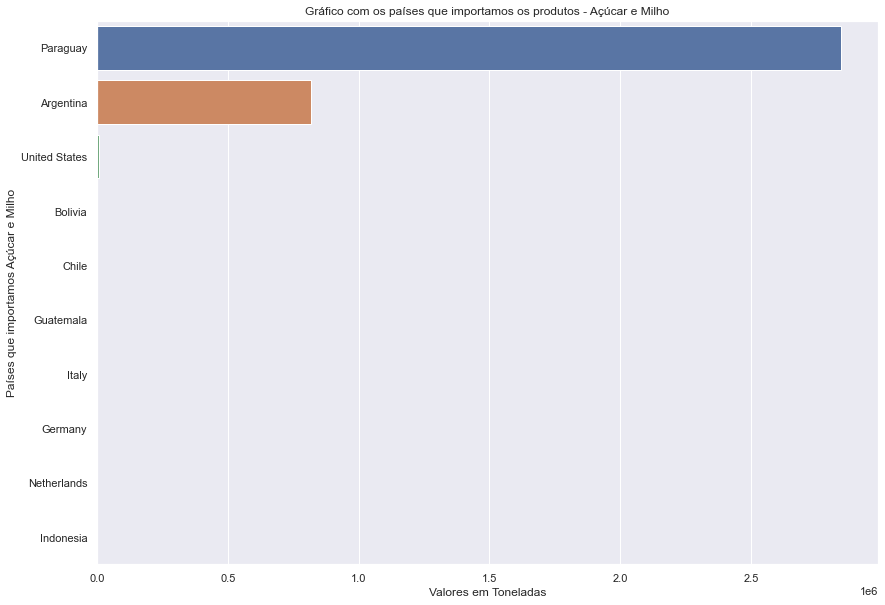

In [52]:
sns.barplot(data = df_most_ctr_impt, x = 'tons', y = 'country');
plt.title('Gráfico com os países que importamos os produtos - Açúcar e Milho');
plt.xlabel('Valores em Toneladas');
plt.ylabel('Países que importamos Açúcar e Milho');

<span style='color:black'>
    Olhando os cenários dos países que exportam açúcar e milho do Brasil, nos dois cenários em renda de dólares e o consumo feito em toneladas, temos o país Irã como o que exportam mais esses nossos produtos.<br>Depois de acordo respectivamente com cada cenário, temos uma mudança de posições. Da para perceber que exportamos bastante para o Japão mais Bangladesh paga muito mais que o Japão e neste ponto podemos explorar se há algum acordo do Brasil com o Japão para importar tecnologias, o qual é um ponto onde o Brasil hoje não é referência e somos consumidores.<br>Mesmo nos dois cenários existe a predominação de países asiáticos e africanos.
    <br>
    <br>
    Agora, olhando os cenários de importação que realizamos de açúcar e milho do Brasil, aos dois cenários, temos os três principais países que consumimos:
    <ol>
        <li>Paraguai</li>
        <li>Argentina</li>
        <li>Estados Unidos</li>
    </ol>
    Podemos elencar essa relação comercial com esses países, devido ao Mercosul com Paraguai e Argentina e a relação dos últimos anos no qual o Brasil ficou mais próximo, pois Bolsonaro é um admirador de Donald Trump e o mesmo precisava expandir suas relações para diminuir a influência da China. <br>Em comparação com os dois países sul americanos, adquirimos os produtos dos EUA em menor quantidade, mas os EUA é um dos principais países que temos relação comercial. <br>Vale atentar que com pouca quantidade que consumimos dos EUA, gastamos considerávelmente para importar os seus produtos.
</span>

### For each of the products in the dataset, show the 5 most important states in terms of exports?

#### Usando o campo USD

In [53]:
# Selecionar somente os produtos exportados
attr = 'Export'

# Gerar um novo dataset com somente os produtos exportados
df_products = df_govstat.query('type == @attr')

lst_attr = ['product', 'state']
attr = 'usd'

# Agruparei pelo produto e estado e sumarizarei o campo usd.
df_most_states_usd = df_products.groupby(lst_attr)[attr].apply(lambda x: x.sum())

# Ordenando os valores de forma que o dataframe possua os cinco primeiros estados com importância na exportação - usd
#df_most_states_usd = df_most_states_usd.sort_values(ascending=False)

lst_attr = ['product', 'usd']

df_most_states_exp = df_most_states_usd.reset_index()
df_most_states_ord = df_most_states_exp.sort_values(lst_attr, ascending=False)

print(f'Os estados mais importantes na exportação dos produtos: - Atributo USD\n')

df_most_states_ord.head(10)

Os estados mais importantes na exportação dos produtos: - Atributo USD



product state           usd
133   wheat    RS  1.555925e+09
130   wheat    PR  1.839354e+08
134   wheat    SC  2.540009e+07
135   wheat    SP  2.267024e+06
129   wheat    MS  2.757330e+05
128   wheat    MG  3.960000e+04
131   wheat    RJ  3.124800e+04
126   wheat    GO  1.634900e+04
132   wheat    RO  3.275000e+03
125   wheat    ES  3.300000e+02

In [54]:
product = ''
cont = 0

lst_dtf = []

product = df_most_states_ord.values[0][0]

for dtf in df_most_states_ord.values:    

    if cont < 5:
        lst_dtf.append((list(dtf)))
        
    cont += 1
    
    if dtf[0] != product:
        cont = 0
        product = dtf[0]
        
dtf_most_states = pd.DataFrame(lst_dtf, columns = df_most_states_ord.columns)
dtf_most_states.head(10)

product state           usd
0   wheat    RS  1.555925e+09
1   wheat    PR  1.839354e+08
2   wheat    SC  2.540009e+07
3   wheat    SP  2.267024e+06
4   wheat    MS  2.757330e+05
5   sugar    MG  8.559401e+09
6   sugar    PR  8.270779e+09
7   sugar    AL  4.826419e+09
8   sugar    MS  3.219035e+09
9   sugar    GO  3.040882e+09

In [55]:
wheat = 'wheat'
sugar = 'sugar'
corn  = 'corn'
sbs = 'soybeans' 
sbso = 'soybean_oil'
sbsm = 'soybean_meal'

# Separa os produtos em diferentes dataFrame para facilitar no subplot
wht = dtf_most_states.query('product == @wheat')
sgr = dtf_most_states.query('product == @sugar')
crn = dtf_most_states.query('product == @corn')
sbs = dtf_most_states.query('product == @sbs')
sbs_o = dtf_most_states.query('product == @sbso')
sbs_m = dtf_most_states.query('product == @sbsm')

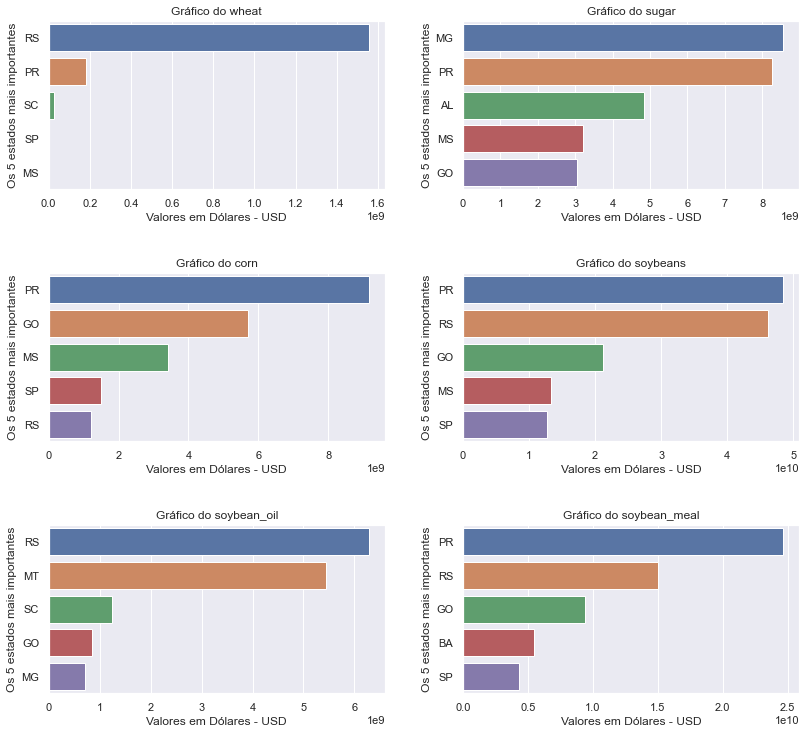

In [56]:
fig = plt.figure(figsize=(12,11))

lst_subplot = [321, 322, 323, 324, 325, 326]
lst_dtf = [wht, sgr, crn, sbs, sbs_o, sbs_m]

for i, dtf in zip(lst_subplot, lst_dtf):
    axs = fig.add_subplot(i)
    axs.set_title(f'Gráfico do {dtf.iloc[0,0]}');
    sns.barplot(data = dtf, x = dtf.columns[2], y = dtf.columns[1], ax = axs);
    axs.set_xlabel('Valores em Dólares - USD');
    axs.set_ylabel('Os 5 estados mais importantes');
    
    fig.tight_layout(pad=3.0);

#### Utilizando o atributo tons

In [57]:
lst_attr = ['product', 'state']
attr = 'tons'

# Agruparei pelo produto e estado e sumarizarei o campo usd.
df_most_states_tons = df_products.groupby(lst_attr)[attr].apply(lambda x: x.sum())

lst_attr = ['product', attr]

df_most_states_tons = df_most_states_tons.reset_index()
df_most_states_ord_t = df_most_states_tons.sort_values(lst_attr, ascending=False)

print(f'Os estados mais importantes na exportação dos produtos: - Atributo Tons\n')

df_most_states_ord_t.head(10)

Os estados mais importantes na exportação dos produtos: - Atributo Tons



product state         tons
133   wheat    RS  6734981.032
130   wheat    PR   824974.624
134   wheat    SC    81340.920
135   wheat    SP    10066.817
129   wheat    MS      910.108
128   wheat    MG      217.911
126   wheat    GO       39.782
131   wheat    RJ       23.637
132   wheat    RO        1.870
125   wheat    ES        0.180

In [58]:
product = ''
cont = 0

lst_dtf = []

product = df_most_states_ord_t.values[0][0]

for dtf in df_most_states_ord_t.values:    

    if cont < 5:
        lst_dtf.append((list(dtf)))
        
    cont += 1
    
    if dtf[0] != product:
        cont = 0
        product = dtf[0]
        
dtf_most_statest = pd.DataFrame(lst_dtf, columns = df_most_states_ord_t.columns)
dtf_most_statest.head(10)

product state          tons
0   wheat    RS  6.734981e+06
1   wheat    PR  8.249746e+05
2   wheat    SC  8.134092e+04
3   wheat    SP  1.006682e+04
4   wheat    MS  9.101080e+02
5   sugar    MG  2.318293e+07
6   sugar    PR  2.198688e+07
7   sugar    AL  1.261794e+07
8   sugar    MS  8.406289e+06
9   sugar    GO  7.126767e+06

In [59]:
wheat = 'wheat'
sugar = 'sugar'
corn  = 'corn'
sbs = 'soybeans' 
sbso = 'soybean_oil'
sbsm = 'soybean_meal'

# Separa os produtos em diferentes dataFrame para facilitar no subplot
whtt = dtf_most_statest.query('product == @wheat')
sgrt = dtf_most_statest.query('product == @sugar')
crnt = dtf_most_statest.query('product == @corn')
sbst = dtf_most_statest.query('product == @sbs')
sbs_ot = dtf_most_statest.query('product == @sbso')
sbs_mt = dtf_most_statest.query('product == @sbsm')

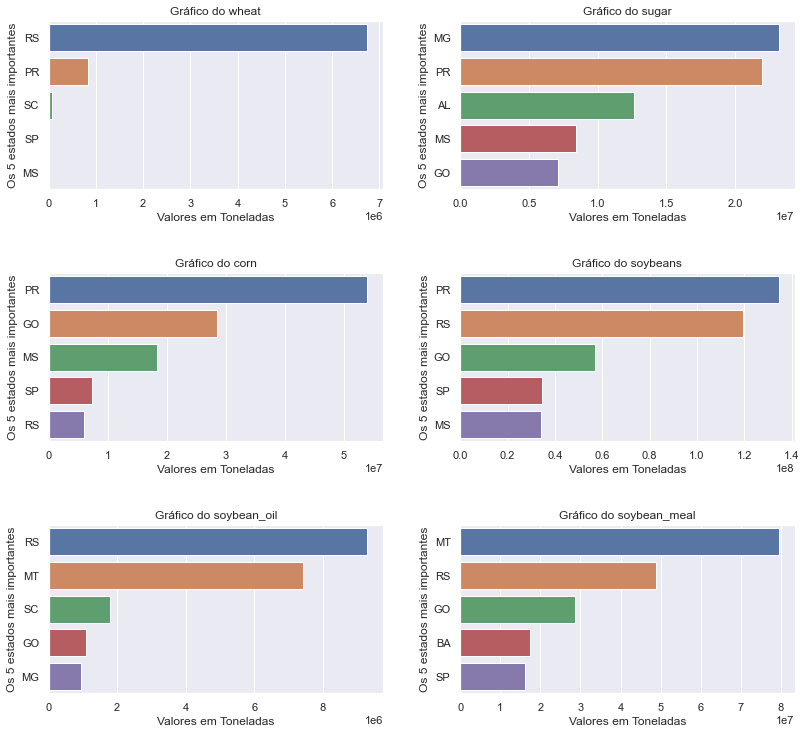

In [60]:
fig = plt.figure(figsize=(12,11))

lst_subplot = [321, 322, 323, 324, 325, 326]
lst_dtf = [whtt, sgrt, crnt, sbst, sbs_ot, sbs_mt]

for i, dtf in zip(lst_subplot, lst_dtf):
    axs = fig.add_subplot(i)
    axs.set_title(f'Gráfico do {dtf.iloc[0,0]}');
    sns.barplot(data = dtf, x = dtf.columns[2], y = dtf.columns[1], ax = axs);
    axs.set_xlabel('Valores em Toneladas');
    axs.set_ylabel('Os 5 estados mais importantes');
    
    fig.tight_layout(pad=3.0);

<span style='color:black'>
    Analisando os cenários com os atributos usd e tons, a ordem dos estados para os seis produtos foram semelhantes, exceto na ordem do produto soybeans, o qual o estado de SP passa o MS.<br>A maioria dos estados importantes para os produtos são: do Sul, Sudeste e Centro-Oeste. Somente o estado de Alagoas, Nordeste, que faz parte dos cinco estados mais importantes no produto do açúcar.<br><br>Observa-se que em quatro produtos temos o estado do Sul em primeiro lugar, ora com Rio Grande do Sul e ora com Paraná. Por fim, temos um do Sudeste, Minas Gerais, e temos um do Centro-Oeste, Mato Grosso.
</span>

### Now, we ask you to show your modelling skills. Feel free to use any type of modelling approach, but bear in mind that the modelling approach depends on the nature of your data, and so different models yield different estimates and forecasts. To help you out in this task we also provide you with a dataset of possible covariates (.xlsx). They all come from public sources (IMF, World Bank) and are presented in index number format. Question: What should be the total brazilian soybeans, soybean_meal, and corn export forecasts, in tons, for the next 11 years (2020-2030)? We’re mostly interested in the annual forecast.

In [61]:
# Fazendo a leitura dos dados
df_covaria = pd.read_excel(f'{pkgdir}\\{covariat}')
#df_covaria = pd.read_excel(f'{covariat}')

# Visualizando os 5 primeiros registros
df_covaria.head(5)

year  price_soybeans  price_corn  price_soybean_meal   gdp_china  \
0  1979             NaN         NaN                 NaN  100.000000   
1  1980      100.000000  100.000000          100.000000  107.900000   
2  1981       98.525508  103.888308           99.805440  113.402900   
3  1982       83.406192   85.986430           86.596956  123.609161   
4  1983       97.851743  108.168059           98.663318  136.958950   

     gdp_iran  gpd_netherlands   gdp_spain  gdp_thailand   gdp_world  \
0  100.000000              NaN  100.000000    100.000000  100.000000   
1   81.200000       100.000000  101.200000    104.600000  102.100000   
2   74.216800        99.500000  100.795200    110.771400  104.039900   
3   83.939201        98.206500  102.004742    116.753056  104.664139   
4   95.522811        99.974217  103.738823    123.291227  107.594735   

    gdp_egypt   gdp_japan  gdp_vietnam  
0  100.000000  100.000000   100.000000  
1  103.400000  103.200000    96.500000  
2  105.674800  107.534400   102.097000  
3  113.389060  111.083035   110.468954  
4  123.480687  114.970941   118.312250

In [62]:
print(f'Tamanho do dataset:\n{df_covaria.shape}')

Tamanho do dataset:
(52, 13)


#### Análise Exploratória dos Dados

In [63]:
ExibirTiposVariaveis(df_covaria)

year - tipo: int64

price_soybeans - tipo: float64

price_corn - tipo: float64

price_soybean_meal - tipo: float64

gdp_china - tipo: float64

gdp_iran - tipo: float64

gpd_netherlands - tipo: float64

gdp_spain - tipo: float64

gdp_thailand - tipo: float64

gdp_world - tipo: float64

gdp_egypt - tipo: float64

gdp_japan - tipo: float64

gdp_vietnam - tipo: float64



In [64]:
IdentificarValoresNulos(df_covaria)

Os valores nulos são:
year                  0
price_soybeans        1
price_corn            1
price_soybean_meal    1
gdp_china             0
gdp_iran              0
gpd_netherlands       1
gdp_spain             0
gdp_thailand          0
gdp_world             0
gdp_egypt             0
gdp_japan             0
gdp_vietnam           0
dtype: int64


In [65]:
IdentificarValoresDuplicados(df_covaria)

Os valores duplicados são:
False    52
dtype: int64


In [66]:
# Correção dos valores NaN
values = {'price_soybeans' : 0.2, 'price_corn' : 0.2, 'price_soybean_meal' : 0.2, 'gpd_netherlands' : 0.2}

# Criando uma lista com os atributos que terei que ajustar os seus valores
lst_attr = ['price_soybeans', 'price_corn', 'price_soybean_meal', 'gpd_netherlands']

# Adotei uma estratégia de substituir os NaNs por 0.2 e remover do próximo ano 0.2 das colunas com not a number.
df_covaria.fillna(value = values, inplace = True)
df_covaria.loc[1, lst_attr] = df_covaria.iloc[1][lst_attr] - 0.2

df_covaria.iloc[0:2]

year  price_soybeans  price_corn  price_soybean_meal  gdp_china  gdp_iran  \
0  1979             0.2         0.2                 0.2      100.0     100.0   
1  1980            99.8        99.8                99.8      107.9      81.2   

   gpd_netherlands  gdp_spain  gdp_thailand  gdp_world  gdp_egypt  gdp_japan  \
0              0.2      100.0         100.0      100.0      100.0      100.0   
1             99.8      101.2         104.6      102.1      103.4      103.2   

   gdp_vietnam  
0        100.0  
1         96.5

#### Ajuste do index

In [67]:
df_covaria.set_index('year', inplace=True)

In [68]:
lst_attr = ['price_soybeans', 'price_corn', 'price_soybean_meal']

df_covar = df_covaria.loc[2020:, lst_attr]

df_covar.head(3)

price_soybeans  price_corn  price_soybean_meal
year                                                
2020      116.920726  127.345508          145.243944
2021      121.166259  130.855976          148.695213
2022      125.565952  134.463215          152.228491

#### Entendendo os Preços dos Produtos em 2020 à 2030

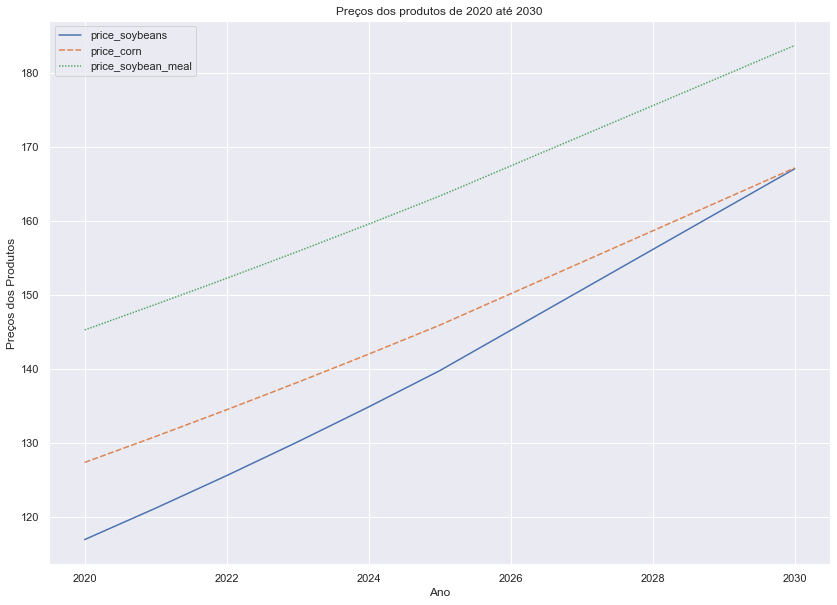

In [69]:
sns.lineplot(data = df_covar);
plt.title('Preços dos produtos de 2020 até 2030');
plt.xlabel('Ano');
plt.ylabel('Preços dos Produtos');

<span style='color:black'>
    Dos três produtos, a valorização do produto soja, soybeans, foi o que teve a maior previsão de incremento entre os anos 2020 e 2030.<br>Verificarei se ocorrerá o incremento de vendas em toneladas.
</span>

#### Trabalhando com o conjunto de dados data_comexstat

In [70]:
attr = 'Export'
lst_attr = ['soybeans', 'soybean_meal', 'corn']
lst_attb = ['date', 'product']
fields = ['tons']

df_prod_exp_for = df_govstat.query('type == @attr and product == @lst_attr').groupby(lst_attb).apply(lambda x: x.sum())[fields]
df_prod_exp_for.reset_index(inplace=True)
df_prod_exp_for.head(5)

date       product        tons
0  1997-01-01          corn  170407.730
1  1997-01-01  soybean_meal  486775.060
2  1997-01-01      soybeans   14030.000
3  1997-02-01          corn   96868.464
4  1997-02-01  soybean_meal  176535.716

In [71]:
fields = ['date', 'tons']

# Diferentes dataframes para predizer a série de cada produto
df_sbs_for = df_prod_exp_for.query('product == @sbs')[fields]
df_sbm_for = df_prod_exp_for.query('product == @sbsm')[fields]
df_crn_for = df_prod_exp_for.query('product == @corn')[fields]

In [72]:
# Incluindo a data em índice
df_sbs_for.set_index(lst_attb[0], inplace=True)
df_sbm_for.set_index(lst_attb[0], inplace=True)
df_crn_for.set_index(lst_attb[0], inplace=True)

# E depois inserindo a frequência, neste caso colocarei início do mês 'MS' para não perder os dados de toneladas
df_sbs_for = df_sbs_for.asfreq('MS')
df_sbm_for = df_sbm_for.asfreq('MS')
df_crn_for = df_crn_for.asfreq('MS')

In [73]:
# Produto soybeans
df_sbs_for.head(3)

tons
date                  
1997-01-01   14030.000
1997-02-01   17095.000
1997-03-01  550157.554

In [74]:
# Produto soybeans - índices
df_sbs_for.index

DatetimeIndex(['1997-01-01', '1997-02-01', '1997-03-01', '1997-04-01',
               '1997-05-01', '1997-06-01', '1997-07-01', '1997-08-01',
               '1997-09-01', '1997-10-01',
               ...
               '2019-03-01', '2019-04-01', '2019-05-01', '2019-06-01',
               '2019-07-01', '2019-08-01', '2019-09-01', '2019-10-01',
               '2019-11-01', '2019-12-01'],
              dtype='datetime64[ns]', name='date', length=276, freq='MS')

In [75]:
# Produto soybean_meal
df_sbm_for.head(3)

tons
date                  
1997-01-01  486775.060
1997-02-01  176535.716
1997-03-01  575665.522

In [76]:
# Produto soybean_meal - índices
df_sbm_for.index

DatetimeIndex(['1997-01-01', '1997-02-01', '1997-03-01', '1997-04-01',
               '1997-05-01', '1997-06-01', '1997-07-01', '1997-08-01',
               '1997-09-01', '1997-10-01',
               ...
               '2019-03-01', '2019-04-01', '2019-05-01', '2019-06-01',
               '2019-07-01', '2019-08-01', '2019-09-01', '2019-10-01',
               '2019-11-01', '2019-12-01'],
              dtype='datetime64[ns]', name='date', length=276, freq='MS')

In [77]:
# Produto corn
df_crn_for.head(3)

tons
date                  
1997-01-01  170407.730
1997-02-01   96868.464
1997-03-01   48452.425

In [78]:
# Produto soybean_meal - índices
df_crn_for.index

DatetimeIndex(['1997-01-01', '1997-02-01', '1997-03-01', '1997-04-01',
               '1997-05-01', '1997-06-01', '1997-07-01', '1997-08-01',
               '1997-09-01', '1997-10-01',
               ...
               '2019-03-01', '2019-04-01', '2019-05-01', '2019-06-01',
               '2019-07-01', '2019-08-01', '2019-09-01', '2019-10-01',
               '2019-11-01', '2019-12-01'],
              dtype='datetime64[ns]', name='date', length=276, freq='MS')

#### Entendimento de aditivo ou multiplicativo com seasonal decompose

##### Soja com modelo aditivo

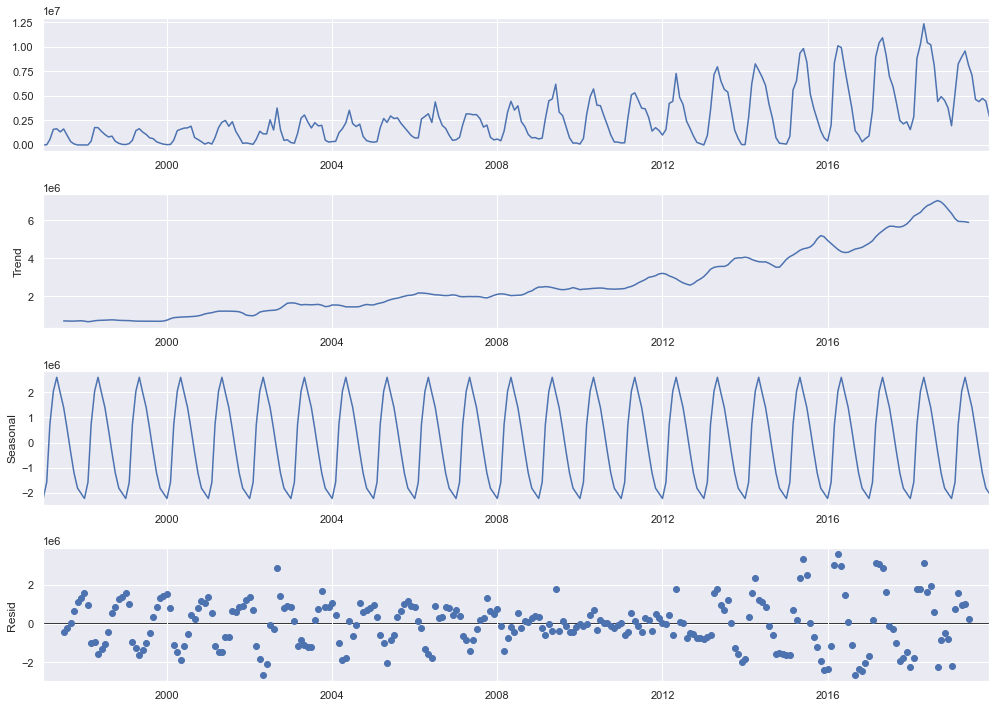

In [79]:
result_sbs_add = seasonal_decompose(df_sbs_for, model='additive')

result_sbs_add.plot();

##### Farinha de Soja com modelo aditivo

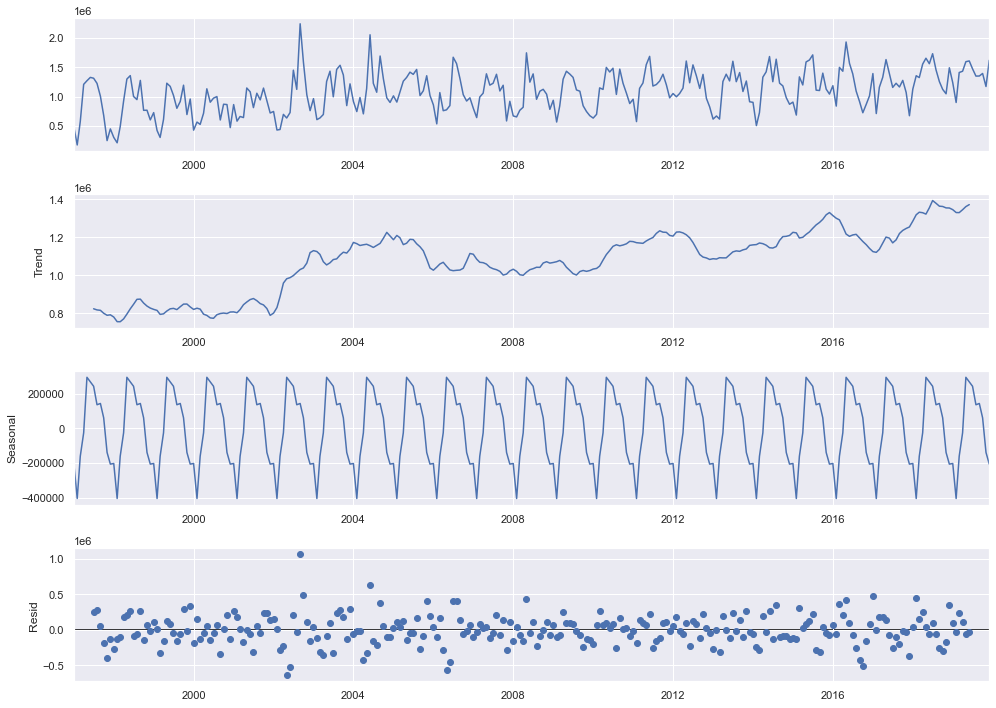

In [80]:
result_sbm_add = seasonal_decompose(df_sbm_for, model='additive')

result_sbm_add.plot();

##### Trigo com modelo aditivo

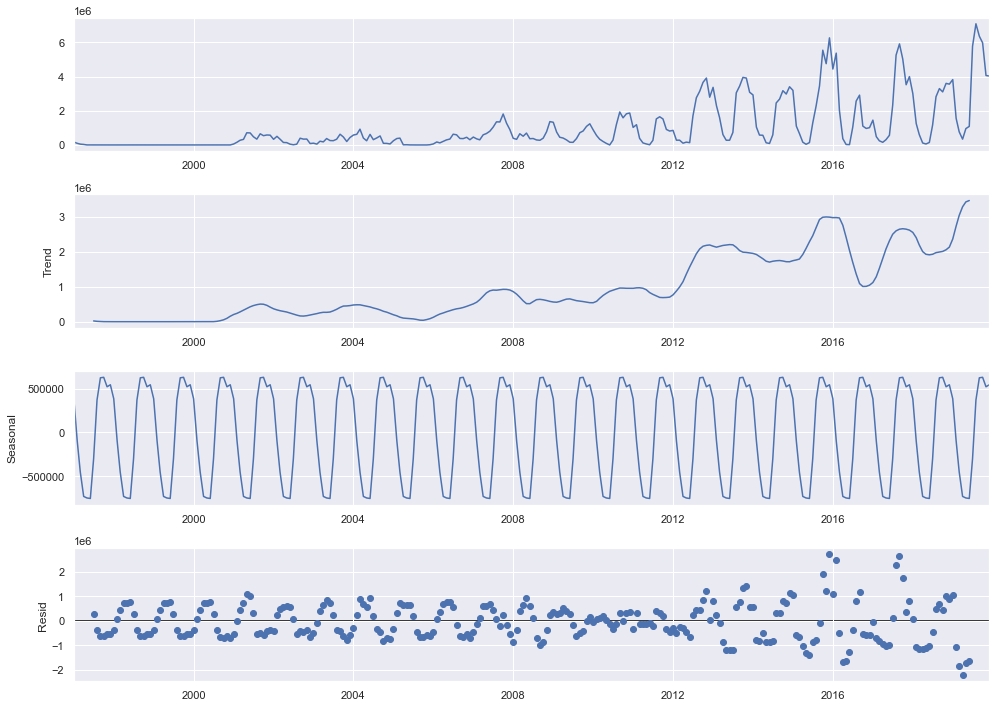

In [81]:
result_crn_add = seasonal_decompose(df_crn_for, model='aaditive')

result_crn_add.plot();

##### Soja com modelo multiplicativo

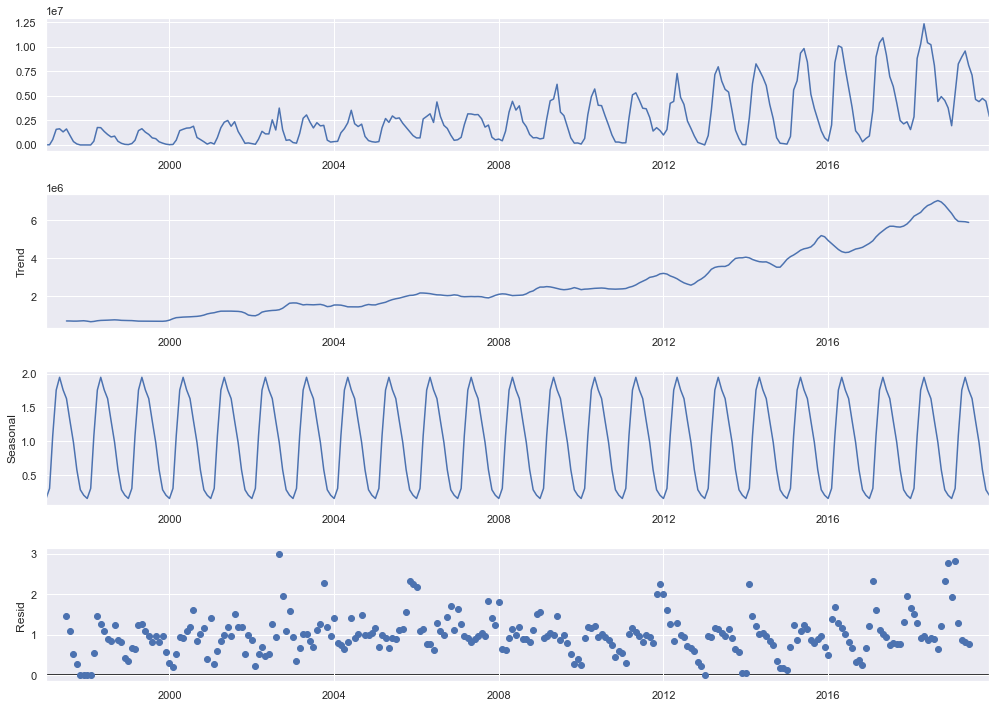

In [82]:
result_sbs_mul = seasonal_decompose(df_sbs_for, model='multiplicative')

result_sbs_mul.plot();

##### Farinha de Soja com modelo multiplicativo

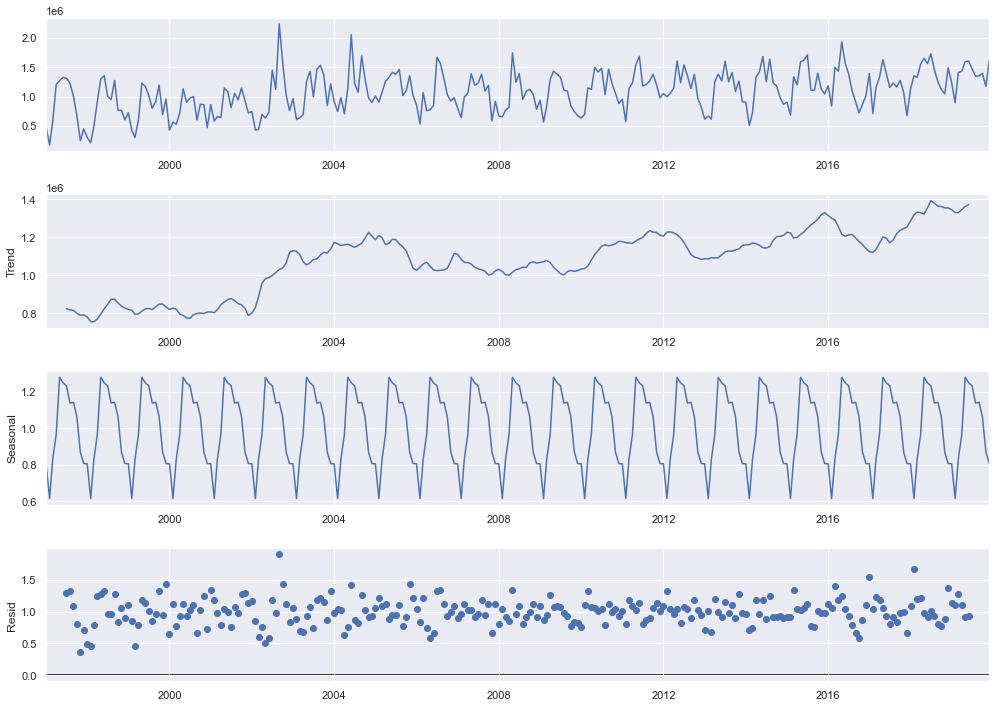

In [83]:
result_sbm_mul = seasonal_decompose(df_sbm_for, model='multiplicative')

result_sbm_mul.plot();

##### Trigo com modelo multiplicativo

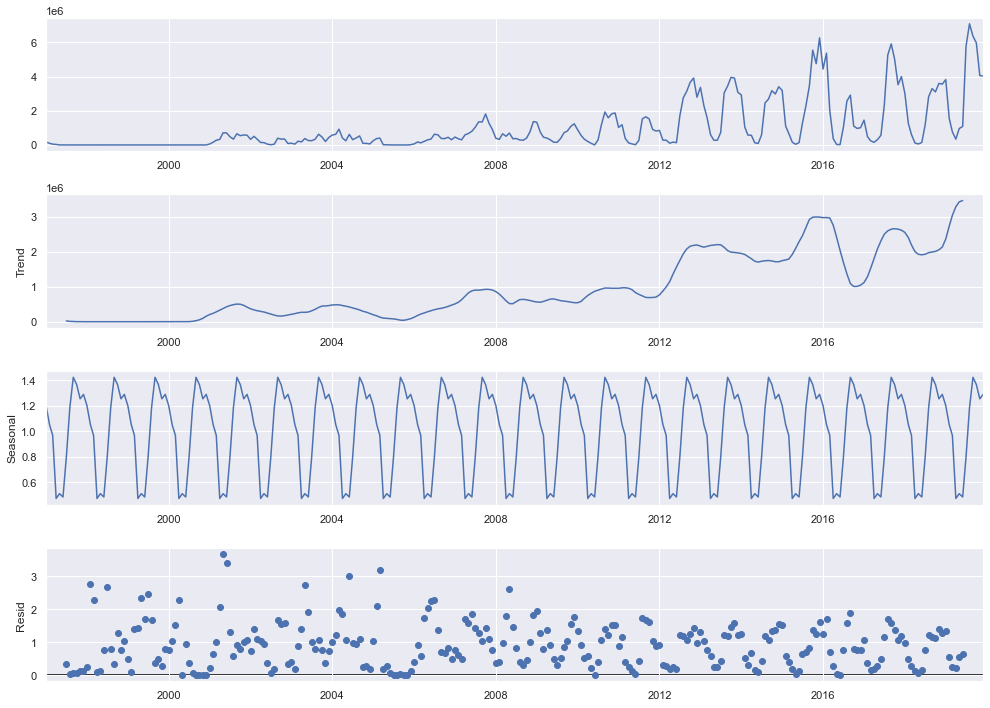

In [84]:
result_crn_mul = seasonal_decompose(df_crn_for, model='multiplicative')

result_crn_mul.plot();

##### Considerações Finais

<span style='color:black'>
    Comparei para cada produto o modelo com aditivo e multiplicativo, com o modelo multiplicativo, os dados tendem a ficar centralizados e não estarem nas regiões com valores negativos.
    <br>Esta comparação ajuda para escolher um método holt-winters multiplicativo, porém trabalharei somente com o SARIMA, presumindo que ocorre sazonalidade. Nos dados observados, intuitivamente percebe que os vales e os picos não possuem regularidade, não seguindo um padrão, isso dá a intuição que os dados possuem sazonalidade.
    <br><br>Observa-se que os três produtos possuem uma tendência de crescimento a partir de 2012 para frente.
</span>

#### Trabalhando com base de treino e teste para encontrar o melhor modelo SARIMA

##### Base de Soja

In [85]:
# Dividindo a base
dados_treino_sbs, dados_teste_sbs = train_test_split(df_sbs_for, test_size=0.25, random_state=0, shuffle = False)

# Exibir a quantidade de dados de treino e quantidade de dados dos testes
print(f'Tamanho do treino: {len(dados_treino_sbs)}\nTamanho do teste: {len(dados_teste_sbs)}')

Tamanho do treino: 207
Tamanho do teste: 69


##### Base de Farinha de Soja

In [86]:
# Dividindo a base
dados_treino_sbm, dados_teste_sbm = train_test_split(df_sbm_for, test_size=0.25, random_state=0, shuffle = False)

# Exibir a quantidade de dados de treino e quantidade de dados dos testes
print(f'Tamanho do treino: {len(dados_treino_sbm)}\nTamanho do teste: {len(dados_teste_sbm)}')

Tamanho do treino: 207
Tamanho do teste: 69


##### Base de Trigo

In [87]:
# Dividindo a base
dados_treino_crn, dados_teste_crn = train_test_split(df_crn_for, test_size=0.25, random_state=0, shuffle = False)

# Exibir a quantidade de dados de treino e quantidade de dados dos testes
print(f'Tamanho do treino: {len(dados_treino_crn)}\nTamanho do teste: {len(dados_teste_crn)}')

Tamanho do treino: 207
Tamanho do teste: 69


##### Avaliando o melhor modelo SARIMA para Soja

In [88]:
auto_arima(dados_treino_sbs, seasonal=True, m=12).summary()


stepwise_fit_s = auto_arima(dados_treino_sbs, start_p=0, start_q=0,
                          max_p=7, max_q=6, m=12,
                          seasonal=True,
                          trace=True,
                          error_action='ignore',   
                          suppress_warnings=True,  
                          stepwise=True)           

stepwise_fit_s.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=5812.906, Time=0.18 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=5852.580, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=5789.435, Time=0.19 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=5799.909, Time=0.21 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=5863.196, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=5841.214, Time=0.03 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=5789.206, Time=0.66 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=5787.815, Time=1.06 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=5785.815, Time=0.30 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=5791.593, Time=0.19 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=5785.969, Time=1.34 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=5787.656, Time=0.57 sec
 ARIMA(1,0,0)(2,1,2)[12] intercept   : AIC=5787.968, Time=1.56 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=5782.854, Time=0.36 sec
 ARIMA(2,0,0)(0,1,1

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  207
Model:             SARIMAX(5, 0, 0)x(0, 1, [1, 2], 12)   Log Likelihood               -2881.839
Date:                                 Thu, 31 Dec 2020   AIC                           5781.678
Time:                                         05:00:18   BIC                           5811.135
Sample:                                              0   HQIC                          5793.605
                                                 - 207                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.323e+05   3.97e+04      3.333      0.001    5.45e+04     2.1e+05
ar.L1          0.4002      0.087      4.584      0.000       0.229       0.571
ar.L2          0.1515      0.098      1.542      0.123      -0.041       0.344
ar.L3         -0.0664      0.125     -0.529      0.597      -0.312       0.179
ar.L4         -0.1010      0.122     -0.826      0.409      -0.341       0.139
ar.L5         -0.1339      0.139     -0.965      0.334      -0.406       0.138
ma.S.L12      -0.7634      0.122     -6.242      0.000      -1.003      -0.524
ma.S.L24       0.1653      0.104      1.589      0.112      -0.039       0.369
sigma2      5.453e+11      0.013   4.05e+13      0.000    5.45e+11    5.45e+11
===================================================================================
Ljung-Box (Q):                       43.07   Jarque-Bera (JB):               110.94
Prob(Q):                              0.34   Prob(JB):                         0.00
Heteroskedasticity (H):               2.69   Skew:                             1.21
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.47e+29. Standard errors may be unstable.
"""

<span style='color:black'>
    O melhor modelo gerado foi o <strong>SARIMA(5,0,0)(0,1,[1,2])12</strong>.
    <br>Este modelo é composto dos seguintes modelos:
    <br>
    <br>Analisando o primeiro trecho do modelo, (p,d,q) - componentes não-sazonais
    <ul>
        <li><strong>5 componentes autoregressiva não-sazonal de ordem 5.</strong></li>
        <li>0 - Sem componente integrado não-sazonal.</li>
        <li>0  Sem componente de médias móveis não-sazonal.</li>
    </ul>
    <br>
    <br>Analisando o segundo trecho do modelo, (P,D,Q) - componentes sazonais mais o m
    <ul>
        <li>0 componente autoregressiva sazonal.</li>
        <li><strong>1 - Componente integrado sazonal de ordem 1.</strong></li>
        <li><strong>[1,2] componente(s) de médias móveis sazonal de ordem [1,2]</strong>.</li>
    </ul>
    <br>O m representa o período da sazonalidade, definido por 12.
</span>

##### Treinando o melhor modelo SARIMA para Soja

In [89]:
# Treinando com o melhor modelo
modelo_sbs = SARIMAX(dados_treino_sbs,order=(5,0,0),seasonal_order=(0,1,2,12))

resultado_sbs = modelo_sbs.fit()
resultado_sbs.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                    tons   No. Observations:                  207
Model:             SARIMAX(5, 0, 0)x(0, 1, [1, 2], 12)   Log Likelihood               -2890.608
Date:                                 Thu, 31 Dec 2020   AIC                           5797.216
Time:                                         05:00:19   BIC                           5823.400
Sample:                                     01-01-1997   HQIC                          5807.818
                                          - 03-01-2014                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4418      0.083      5.301      0.000       0.278       0.605
ar.L2          0.2144      0.088      2.450      0.014       0.043       0.386
ar.L3         -0.0338      0.120     -0.281      0.779      -0.270       0.202
ar.L4         -0.0357      0.120     -0.298      0.766      -0.271       0.199
ar.L5         -0.0159      0.127     -0.125      0.900      -0.265       0.233
ma.S.L12      -0.6466      0.104     -6.242      0.000      -0.850      -0.444
ma.S.L24       0.1780      0.091      1.963      0.050       0.000       0.356
sigma2      5.605e+11   1.34e-13   4.18e+24      0.000     5.6e+11     5.6e+11
===================================================================================
Ljung-Box (Q):                       49.78   Jarque-Bera (JB):               104.53
Prob(Q):                              0.14   Prob(JB):                         0.00
Heteroskedasticity (H):               2.53   Skew:                             1.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.5e+40. Standard errors may be unstable.
"""

##### Previsão com o melhor modelo SARIMA para Soja utilizando base de teste

In [90]:
# Obtendo valores preditos do Sarima(5,0,0)(0,1,2,12)
inicio=len(dados_treino_sbs)
fim=len(dados_treino_sbs) + len(dados_teste_sbs) - 1

previsoes_sbs = resultado_sbs.predict(start=inicio, end=fim, dynamic=False, typ='levels').\
            rename('Previsões SARIMA(5,0,0)(0,1,2,12) ')
previsoes_sbs.index = dados_teste_sbs.index

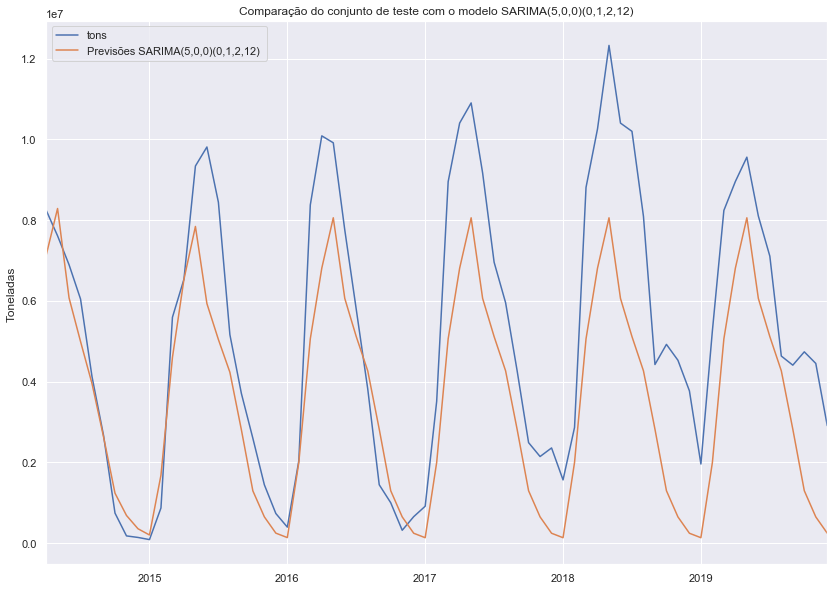

In [91]:
ylabel='Toneladas '
xlabel=''
title_sarima = 'Comparação do conjunto de teste com o modelo SARIMA(5,0,0)(0,1,2,12)'

ax = dados_teste_sbs.plot(legend=True, title=title_sarima, label='Teste')
previsoes_sbs.plot(legend=True)

ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

##### Predizendo por mais de 10 anos o produto de Soja

In [92]:
modelo_sbs = SARIMAX(df_sbs_for, order=(5,0,0), seasonal_order=(0,1,2,12), enforce_invertibility=False)

resultado_sarima_sbs = modelo_sbs.fit()

inicio=len(df_sbs_for)
fim=len(df_sbs_for) + 120

fcast   = resultado_sarima_sbs.get_prediction(start=inicio, end=fim)
pred_ip =  fcast.conf_int(alpha = 0.05)

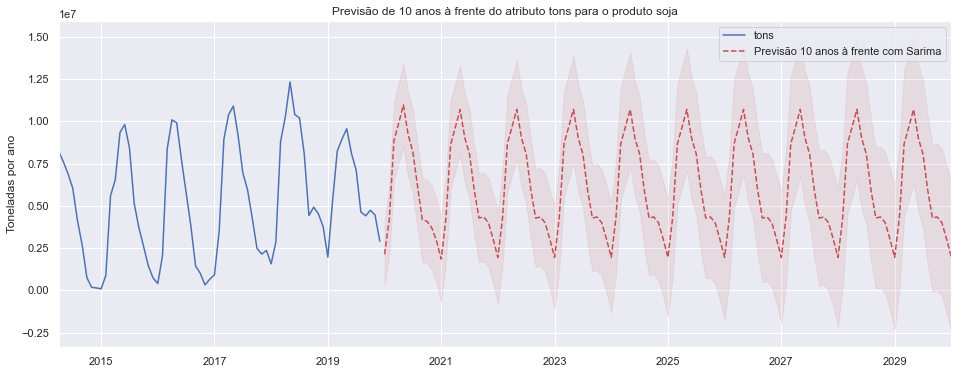

In [93]:
title='Previsão de 10 anos à frente do atributo tons para o produto soja'
ylabel='Toneladas por ano'
xlabel=''

ax = dados_teste_sbs.plot(legend=True,figsize=(16,6),title=title)

fcast.predicted_mean.plot(ax=ax, style='r--', label='Previsão 10 anos à frente com Sarima', legend=True)
ip = pred_ip.loc[dados_teste_sbs.index.max() :]
ax.fill_between(ip.index, ip.iloc[:,0], ip.iloc[:,1], color='r', alpha=0.1)

ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

##### Avaliando o melhor modelo SARIMA para Farinha de Soja

In [94]:
auto_arima(dados_treino_sbm, seasonal=True, m=12).summary()


stepwise_fit_m = auto_arima(dados_treino_sbm, start_p=0, start_q=0,
                          max_p=7, max_q=6, m=12,
                          seasonal=True,
                          trace=True,
                          error_action='ignore',   
                          suppress_warnings=True,  
                          stepwise=True)           

stepwise_fit_m.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=5786.743, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=5803.411, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=5773.511, Time=0.11 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=5778.450, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=5801.416, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=5792.270, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=5772.142, Time=0.31 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=5762.679, Time=1.05 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=5761.310, Time=0.25 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=5779.717, Time=0.09 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=5762.306, Time=0.88 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=5774.937, Time=0.29 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=1.16 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=5755.230, Time=0.37 sec
 ARIMA(2,1,0)(0,0,1)[12]

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  207
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood               -2859.549
Date:                            Thu, 31 Dec 2020   AIC                           5729.097
Time:                                    05:01:56   BIC                           5745.737
Sample:                                         0   HQIC                          5735.827
                                            - 207                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3121      0.107      2.928      0.003       0.103       0.521
ma.L1         -0.9610      0.038    -25.564      0.000      -1.035      -0.887
ar.S.L12       0.9822      0.030     32.344      0.000       0.923       1.042
ma.S.L12      -0.8745      0.122     -7.146      0.000      -1.114      -0.635
sigma2      9.062e+10   1.09e-12    8.3e+22      0.000    9.06e+10    9.06e+10
===================================================================================
Ljung-Box (Q):                       61.59   Jarque-Bera (JB):               110.56
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               0.42   Skew:                             0.98
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.91e+38. Standard errors may be unstable.
"""

<span style='color:black'>
    O melhor modelo gerado foi o <strong>SARIMA(1,1,1)(1,0,1)12</strong>.
    <br>Este modelo é composto dos seguintes modelos:
    <br>
    <br>Analisando o primeiro trecho do modelo, (p,d,q) - componentes não-sazonais
    <ul>
        <li><strong>1 componente autoregressiva não-sazonal de ordem 1.</strong></li>
        <li><strong>1 componente integrado não-sazonal de ordem 1 </strong>.</li>
        <li><strong>1 componente de médias móveis não-sazonal de ordem 1 </strong>.</li>
    </ul>
    <br>
    <br>Analisando o segundo trecho do modelo, (P,D,Q) - componentes sazonais mais o m
    <ul>
        <li><strong> 1 componente autoregressiva sazonal de ordem 1.</strong></li>
        <li> Sem componente integrado sazonal.</li>
        <li><strong>1 componente de médias móveis sazonal de ordem 1.</strong></li>
    </ul>
    <br>O m representa o período da sazonalidade, definido por 12.
</span>

##### Treinando o melhor modelo SARIMA para Farinha de Soja

In [95]:
# Treinando com o melhor modelo
modelo_sbm = SARIMAX(dados_treino_sbm,order=(1,1,1),seasonal_order=(1,0,1,12))

resultado_sbm = modelo_sbm.fit()
resultado_sbm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                               tons   No. Observations:                  207
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood               -2859.549
Date:                            Thu, 31 Dec 2020   AIC                           5729.097
Time:                                    05:01:56   BIC                           5745.737
Sample:                                01-01-1997   HQIC                          5735.827
                                     - 03-01-2014                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3121      0.107      2.928      0.003       0.103       0.521
ma.L1         -0.9610      0.038    -25.564      0.000      -1.035      -0.887
ar.S.L12       0.9822      0.030     32.344      0.000       0.923       1.042
ma.S.L12      -0.8745      0.122     -7.146      0.000      -1.114      -0.635
sigma2      9.062e+10   1.09e-12    8.3e+22      0.000    9.06e+10    9.06e+10
===================================================================================
Ljung-Box (Q):                       61.59   Jarque-Bera (JB):               110.56
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               0.42   Skew:                             0.98
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.91e+38. Standard errors may be unstable.
"""

##### Previsão com o melhor modelo SARIMA para Farinha de Soja utilizando base de teste

In [96]:
# Obtendo valores preditos do Sarima(1,1,1)(1,0,1,12)
inicio=len(dados_treino_sbm)
fim=len(dados_treino_sbm) + len(dados_teste_sbm) - 1

previsoes_sbm = resultado_sbm.predict(start=inicio, end=fim, dynamic=False, typ='levels').\
            rename('Previsões SARIMA(1,1,1)(1,0,1,12) ')
previsoes_sbm.index = dados_teste_sbm.index

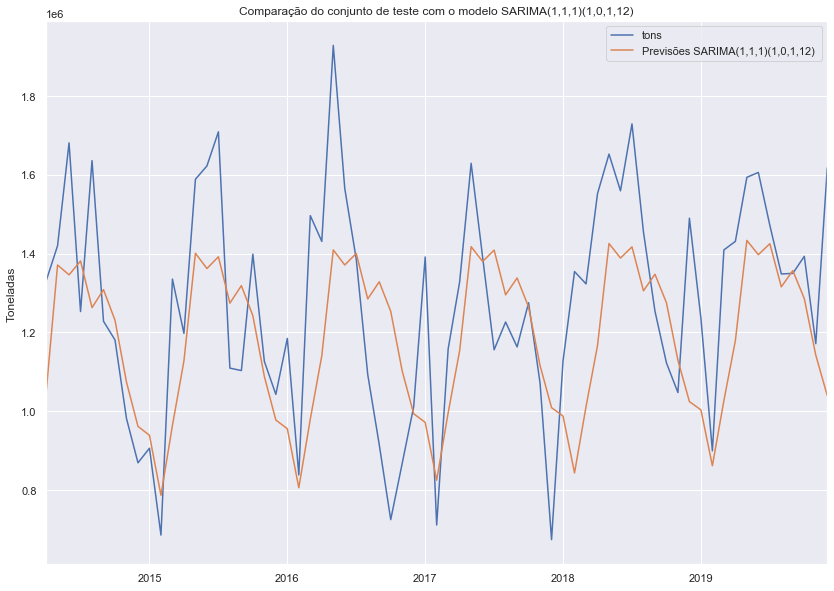

In [97]:
ylabel='Toneladas '
xlabel=''
title_sarima = 'Comparação do conjunto de teste com o modelo SARIMA(1,1,1)(1,0,1,12)'

ax = dados_teste_sbm.plot(legend=True, title=title_sarima, label='Teste')
previsoes_sbm.plot(legend=True)

ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

##### Predizendo por mais de 10 anos o produto Farinha de Soja

In [98]:
modelo_sbm = SARIMAX(df_sbm_for, order=(1,1,1), seasonal_order=(1,0,1,12), enforce_invertibility=False)

resultado_sarima_sbm = modelo_sbm.fit()

inicio=len(df_sbm_for)
fim=len(df_sbm_for) + 120

fcastm  = resultado_sarima_sbm.get_prediction(start=inicio, end=fim)
pred_ip =  fcastm.conf_int(alpha = 0.1)

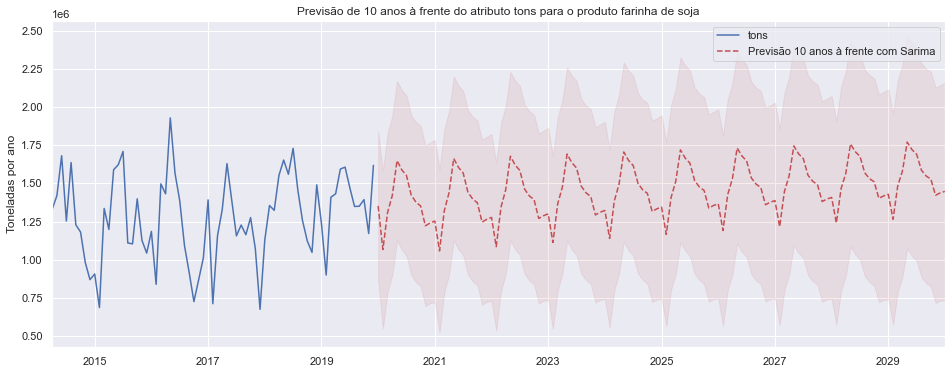

In [99]:
title='Previsão de 10 anos à frente do atributo tons para o produto farinha de soja'
ylabel='Toneladas por ano'
xlabel=''

ax = dados_teste_sbm.plot(legend=True,figsize=(16,6),title=title)

fcastm.predicted_mean.plot(ax=ax, style='r--', label='Previsão 10 anos à frente com Sarima', legend=True)
ip = pred_ip.loc[dados_teste_sbm.index.max() :]
ax.fill_between(ip.index, ip.iloc[:,0], ip.iloc[:,1], color='r', alpha=0.1)

ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

##### Avaliando o melhor modelo SARIMA para Trigo

In [100]:
auto_arima(dados_treino_crn, seasonal=True, m=12).summary()


stepwise_fit_n = auto_arima(dados_treino_crn, start_p=0, start_q=0,
                          max_p=7, max_q=6, m=12,
                          seasonal=True,
                          trace=True,
                          error_action='ignore',   
                          suppress_warnings=True,  
                          stepwise=True)           

stepwise_fit_n.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=5833.870, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=5881.407, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=5834.172, Time=0.12 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=5848.521, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=5879.415, Time=0.01 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=5850.709, Time=0.08 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=5835.708, Time=0.07 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=5835.705, Time=0.42 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=5835.767, Time=0.41 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=5841.193, Time=0.25 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=5833.717, Time=0.32 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=5832.115, Time=0.42 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=5834.111, Time=0.71 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=5832.290, Time=0.30 sec
 ARIMA(2,1,0)(2,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  207
Model:             SARIMAX(5, 1, 3)x(2, 0, [], 12)   Log Likelihood               -2881.990
Date:                             Thu, 31 Dec 2020   AIC                           5785.979
Time:                                     05:06:07   BIC                           5822.586
Sample:                                          0   HQIC                          5800.784
                                             - 207                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5851      0.086      6.817      0.000       0.417       0.753
ar.L2         -0.4577      0.092     -4.988      0.000      -0.638      -0.278
ar.L3          0.6530      0.098      6.690      0.000       0.462       0.844
ar.L4         -0.1399      0.112     -1.248      0.212      -0.360       0.080
ar.L5         -0.2559      0.093     -2.746      0.006      -0.439      -0.073
ma.L1         -0.6646      0.053    -12.542      0.000      -0.768      -0.561
ma.L2          0.6553      0.049     13.319      0.000       0.559       0.752
ma.L3         -0.9027      0.047    -19.409      0.000      -0.994      -0.812
ar.S.L12       0.4625      0.094      4.920      0.000       0.278       0.647
ar.S.L24       0.1543      0.092      1.671      0.095      -0.027       0.335
sigma2      9.245e+10   5.17e-13   1.79e+23      0.000    9.24e+10    9.24e+10
===================================================================================
Ljung-Box (Q):                       33.46   Jarque-Bera (JB):               115.83
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):              16.55   Skew:                             0.87
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.28e+39. Standard errors may be unstable.
"""

<span style='color:black'>
    O melhor modelo gerado foi o <strong>SARIMA(5,1,3)(2,0,0)12</strong>.
    <br>Este modelo é composto dos seguintes modelos:
    <br>
    <br>Analisando o primeiro trecho do modelo, (p,d,q) - componentes não-sazonais
    <ul>
        <li><strong>5 componentes autoregressiva não-sazonal de ordem 5.</strong></li>
        <li><strong>1 componente integrado não-sazonal de ordem 1.</strong></li>
        <li><strong>3 componentes de médias móveis não-sazonal de ordem 3.</strong></li>
    </ul>
    <br>
    <br>Analisando o segundo trecho do modelo, (P,D,Q) - componentes sazonais mais o m
    <ul>
        <li><strong>2 componentes autoregressiva sazonal de ordem 2.</strong></li>
        <li>Sem componente integrado sazonal.</li>
        <li>Sem componente de médias móveis sazonal de ordem.</li>
    </ul>
    <br>O m representa o período da sazonalidade, definido por 12.
</span>

##### Treinando o melhor modelo SARIMA para Trigo

In [101]:
# Treinando com o melhor modelo 
modelo_crn = SARIMAX(dados_treino_crn,order=(5,1,3),seasonal_order=(2,0,0,12))

resultado_crn = modelo_crn.fit()
resultado_crn.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                tons   No. Observations:                  207
Model:             SARIMAX(5, 1, 3)x(2, 0, [], 12)   Log Likelihood               -2881.990
Date:                             Thu, 31 Dec 2020   AIC                           5785.979
Time:                                     05:06:11   BIC                           5822.586
Sample:                                 01-01-1997   HQIC                          5800.784
                                      - 03-01-2014                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5851      0.086      6.817      0.000       0.417       0.753
ar.L2         -0.4577      0.092     -4.988      0.000      -0.638      -0.278
ar.L3          0.6530      0.098      6.690      0.000       0.462       0.844
ar.L4         -0.1399      0.112     -1.248      0.212      -0.360       0.080
ar.L5         -0.2559      0.093     -2.746      0.006      -0.439      -0.073
ma.L1         -0.6646      0.053    -12.542      0.000      -0.768      -0.561
ma.L2          0.6553      0.049     13.319      0.000       0.559       0.752
ma.L3         -0.9027      0.047    -19.409      0.000      -0.994      -0.812
ar.S.L12       0.4625      0.094      4.920      0.000       0.278       0.647
ar.S.L24       0.1543      0.092      1.671      0.095      -0.027       0.335
sigma2      9.245e+10   5.17e-13   1.79e+23      0.000    9.24e+10    9.24e+10
===================================================================================
Ljung-Box (Q):                       33.46   Jarque-Bera (JB):               115.83
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):              16.55   Skew:                             0.87
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.28e+39. Standard errors may be unstable.
"""

##### Previsão com o melhor modelo SARIMA para Trigo utilizando base de teste

In [102]:
# Obtendo valores preditos do SARIMA(5,1,3)(2,0,0,12)
inicio=len(dados_treino_crn)
fim=len(dados_treino_crn) + len(dados_teste_crn) - 1

previsoes_crn = resultado_crn.predict(start=inicio, end=fim, dynamic=False, typ='levels').\
            rename('Previsões SARIMA(5,1,3)(2,0,0,12) ')
previsoes_crn.index = dados_teste_crn.index

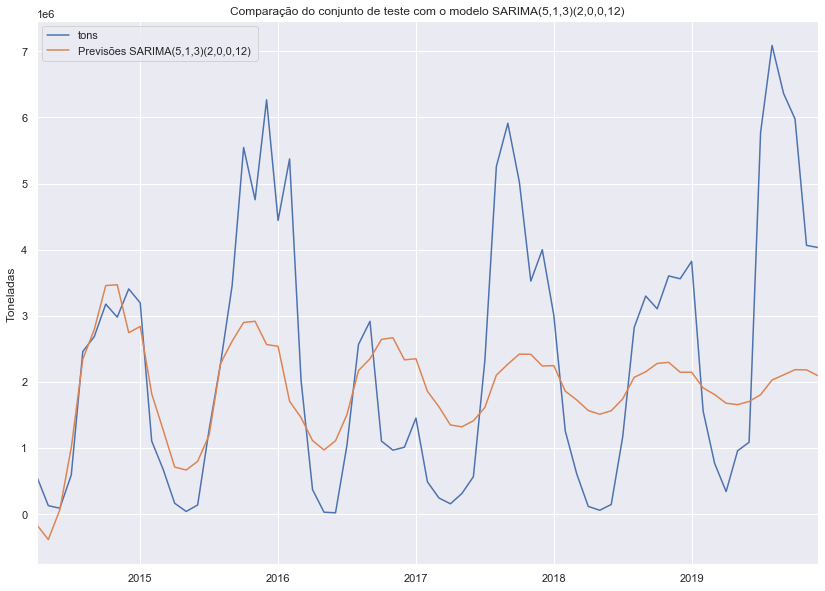

In [103]:
ylabel='Toneladas '
xlabel=''
title_sarima = 'Comparação do conjunto de teste com o modelo SARIMA(5,1,3)(2,0,0,12)'

ax = dados_teste_crn.plot(legend=True, title=title_sarima, label='Teste')
previsoes_crn.plot(legend=True)

ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

##### Predizendo por mais de 10 anos o produto Trigo

In [104]:
modelo_crn = SARIMAX(df_crn_for, order=(5,1,3), seasonal_order=(2,0,0,12), enforce_invertibility=False)

resultado_sarima_crn = modelo_crn.fit()

inicio=len(df_crn_for)
fim=len(df_crn_for) + 120

fcastc  = resultado_sarima_crn.get_prediction(start=inicio, end=fim)
pred_ip =  fcastc.conf_int(alpha = 0.1)

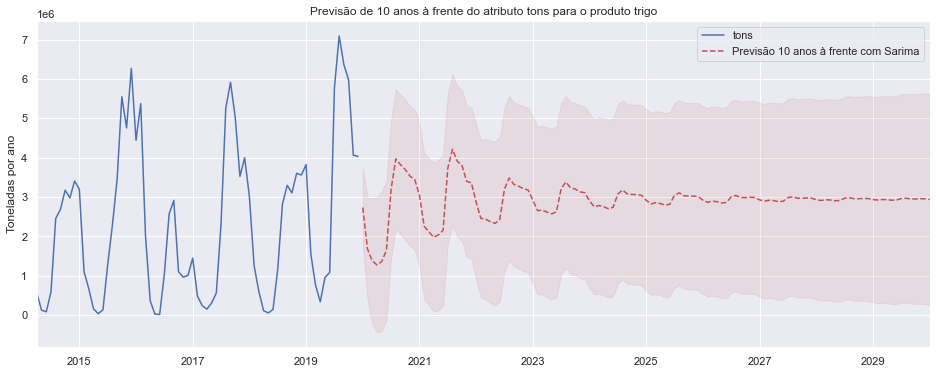

In [105]:
title='Previsão de 10 anos à frente do atributo tons para o produto trigo'
ylabel='Toneladas por ano'
xlabel=''

ax = dados_teste_crn.plot(legend=True,figsize=(16,6),title=title)

fcastc.predicted_mean.plot(ax=ax, style='r--', label='Previsão 10 anos à frente com Sarima', legend=True)
ip = pred_ip.loc[dados_teste_crn.index.max() :]
ax.fill_between(ip.index, ip.iloc[:,0], ip.iloc[:,1], color='r', alpha=0.1)

ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

##### Considerações Finais da predição de 10 anos para os produtos de Soja, Farinha de Soja e Trigo

<span style='color:black'>
    Apesar de alguns produtos, por exemplo o caso de Trigo, onde pude constatar que a predição dos 10 anos à frente mantém em uma média, os demais produtos possuem uma tendência de crescimento em toneladas para exportação, principalmente a Soja.<br>Os produtos, Farinha de Soja e Trigo possuem um intervalo de confiança de 90% para mostrar uma região mais próxima a linha enquanto a Soja teve um intervalo de confiança em 95%, o que fez crescer a região um pouco mais em relação aos outros dois produtos.<br> A região em vermelho permite que a linha tracejada possa se mover dentro dessa região e isso representa, num primeiro momento, que embora aos produtos de Farinha de Soja e, principalmente, o de trigo a predição de 10 anos não foi boa, é razoável e conseguimos compreender a sua tendência nos próximos anos.<br><br>
    Precisei, quando eu gerei os gráficos prevendo mais 10 anos, alterar nos modelos e não utilizar a inversão na média móvel de forma que a linha tracejada representasse de forma mais fidedigna a representação da próxima década. <br><br>
    Meu melhor resultado foi com o produto soja e o pior foi com o produto trigo, mas mesmo assim deixei o mesmo período por avaliar a mesma frequência de datas nos três produtos.
</span>

## Case 1

### Make an exploratory data analysis

In [106]:
# Fazendo a leitura dos dados
df_tfp = pd.read_csv(f'{pkgdir}\\{tfp}', sep = ',', encoding = 'latin1')
#df_tfp = pd.read_csv(f'{tfp}', sep = ',', encoding = 'latin1')

# Visualizando os 5 primeiros registros
df_tfp.head(5)

isocode  year    rtfpna
0     USA  1950  0.617148
1     USA  1951  0.629588
2     USA  1952  0.638451
3     USA  1953  0.651858
4     USA  1954  0.646179

In [107]:
ExibirTiposVariaveis(df_tfp)

isocode - tipo: object

Não numérico, valores:
['USA' 'CAN' 'MEX']

year - tipo: int64

rtfpna - tipo: float64



In [108]:
IdentificarValoresNulos(df_tfp)

Os valores nulos são:
isocode    0
year       0
rtfpna     0
dtype: int64


In [109]:
IdentificarValoresDuplicados(df_tfp)

Os valores duplicados são:
False    186
dtype: int64


In [110]:
df_tfp.describe()

year      rtfpna
count   186.000000  186.000000
mean   1980.500000    0.975614
std      17.943831    0.177538
min    1950.000000    0.617148
25%    1965.000000    0.855143
50%    1980.500000    0.995047
75%    1996.000000    1.046348
max    2011.000000    1.383718

In [147]:
usa = 'USA'
mex = 'MEX'
can = 'CAN'
fields = ['year', 'rtfpna']

# Diferentes dataframes para predizer a série de cada isocode
df_usa = df_tfp.query('isocode == @usa')[fields]
df_mex = df_tfp.query('isocode == @mex')[fields]
df_can = df_tfp.query('isocode == @can')[fields]

In [148]:
# Incluindo a data em índice
df_usa.set_index(fields[0], inplace=True)
df_mex.set_index(fields[0], inplace=True)
df_can.set_index(fields[0], inplace=True)

#### Criando um dataframe para os países, separando-os

##### USA

In [113]:
df_usa.head(3)

rtfpna
year          
1950  0.617148
1951  0.629588
1952  0.638451

##### MEX

In [114]:
df_mex.head(3)

rtfpna
year          
1950  0.798159
1951  0.860931
1952  0.876968

##### CAN

In [115]:
df_can.head(3)

rtfpna
year          
1950  0.843335
1951  0.855123
1952  0.896489

#### Identificando quantos registros cada dtf possui

##### USA

In [116]:
df_usa.shape

(62, 1)

##### MEX

In [117]:
df_mex.shape

(62, 1)

##### CAN

In [118]:
df_can.shape

(62, 1)

#### Olhando o Gráfico do USA

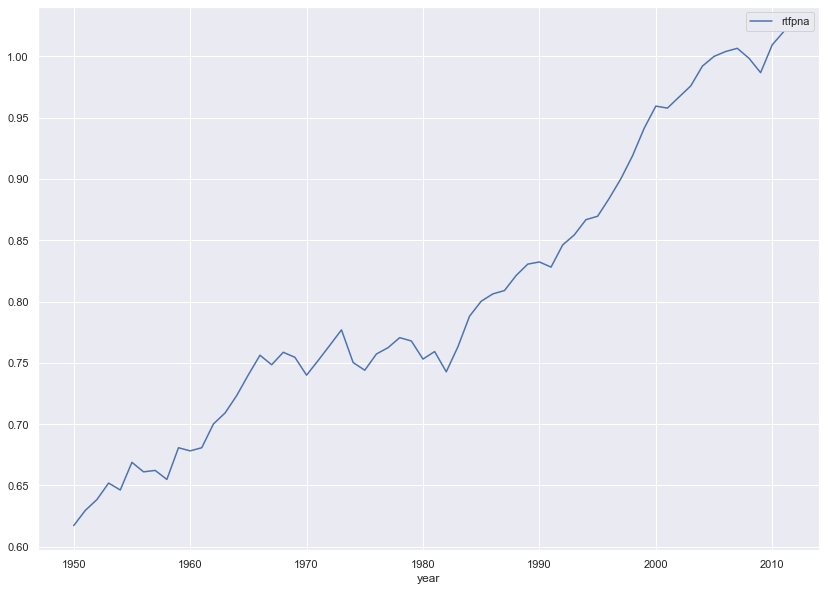

In [119]:
sns.lineplot(data = df_usa);

#### Olhando o Gráfico do MEX

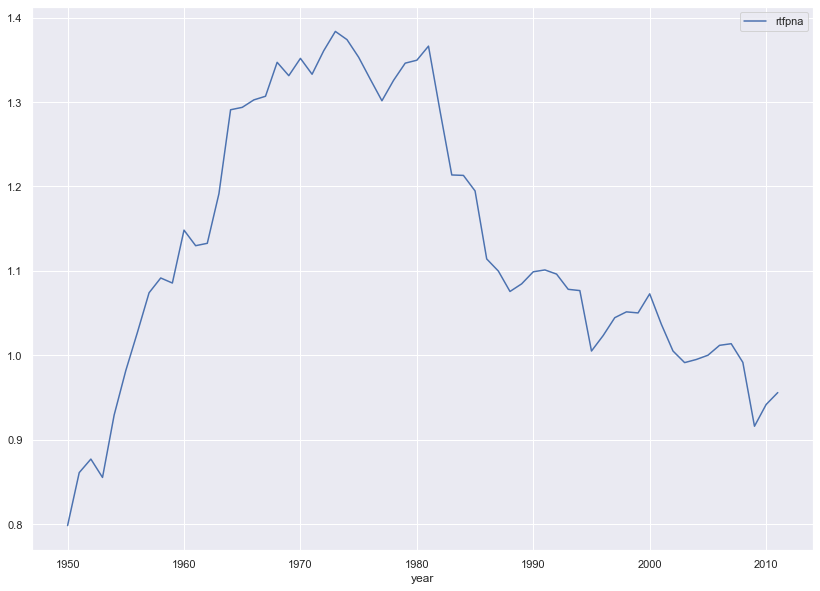

In [120]:
sns.lineplot(data = df_mex);

#### Olhando o Gráfico do CAN

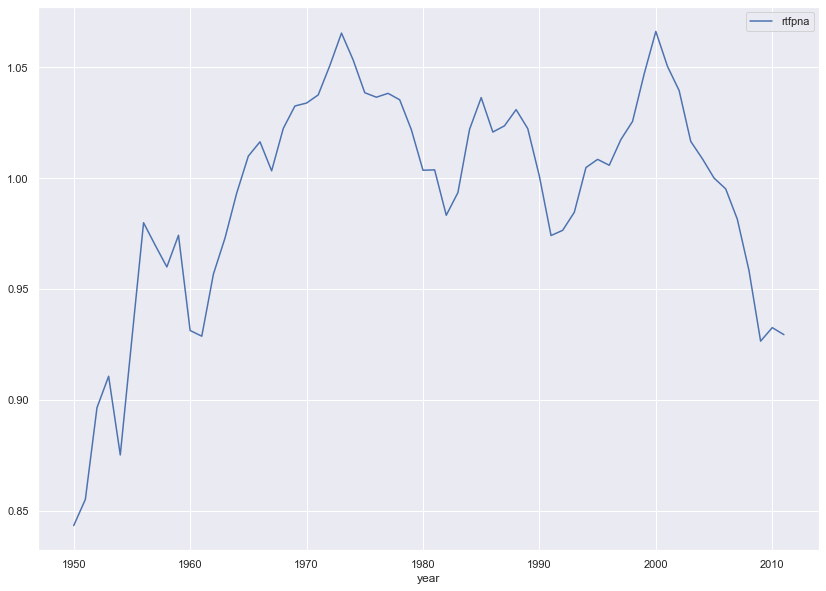

In [121]:
sns.lineplot(data = df_can);

<span style='color:black'>
  Os Estados Unidos teve uma tendência de crescimento em comparação com o Canadá e México.<br>México, entre as décadas de 70 à 80 tinha um número de TFP elevado.<br><br>A partir de 2010 quem possui mais TFP são os Estados Unidos.
</span>

#### Dividindo as bases de treino e teste

In [149]:
# Dividindo a base
dados_treino_usa, dados_teste_usa = train_test_split(df_usa, test_size=0.25, random_state=0, shuffle = False)

# Exibir a quantidade de dados de treino e quantidade de dados dos testes
print(f'Tamanho do treino: {len(dados_treino_usa)}\nTamanho do teste: {len(dados_teste_usa)}')

Tamanho do treino: 46
Tamanho do teste: 16


In [150]:
# Dividindo a base
dados_treino_mex, dados_teste_mex = train_test_split(df_mex, test_size=0.25, random_state=0, shuffle = False)

# Exibir a quantidade de dados de treino e quantidade de dados dos testes
print(f'Tamanho do treino: {len(dados_treino_mex)}\nTamanho do teste: {len(dados_teste_mex)}')

Tamanho do treino: 46
Tamanho do teste: 16


In [151]:
# Dividindo a base
dados_treino_can, dados_teste_can = train_test_split(df_can, test_size=0.25, random_state=0, shuffle = False)

# Exibir a quantidade de dados de treino e quantidade de dados dos testes
print(f'Tamanho do treino: {len(dados_treino_can)}\nTamanho do teste: {len(dados_teste_can)}')

Tamanho do treino: 46
Tamanho do teste: 16


### Forecast 10 years of the series (if you are performing the exercise in R, use package “forecast”);

### Check in the following link pages 2 and 3: https://cran.r-project.org/web/packages/pwt8/pwt8.pdf to see a list of all variables in the original dataset. Can you think about another feature that could be helpful in explaining TFP series? Explain.

<span style='color:black'>
    Depende da situação, para isso eu avaliaria a correlação entre essas variáveis listadas neste link, do conjunto original. Olhando o que cada uma é, eu verificaria a possibilidade de usar a ctfp. <br><br>
    O uso da ctfp é para identificar o nível do TFP atual.    
</span>